In [1]:
from climpyrical.gridding import scale_model_obs
from climpyrical.mask import stratify_coords
from climpyrical.data import read_data, interpolate_dataset, gen_dataset
from climpyrical.rkrig import rkrig_r
from climpyrical.cmd.find_matched_model_vals import add_model_values

from pkg_resources import resource_filename

from sklearn.neighbors import NearestNeighbors
import warnings
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

### Parameters are loaded from config_example.yml
Example configuration from config_example.yml:
```
    paths:
        preprocessed_model_path: /data/results/intermediate/preprocessed_netcdf/
    RL50:
        station_dv: "RL50 (kPa)"
        station_path: 'data/station_inputs/Interim_snow_rain_load_LR_composite_stations_tbd_v4.csv'
        input_model_path: 'data/model_inputs/snw_rain_CanRCM4-LE_ens35_1951-2016_max_rl50_load_ensmean.nc'
        medians: 
            value: 0.4
            action: "multiply"
        fill_glaciers: True
```

In [2]:
# parameter cell

In [3]:
# Parameters
name = "R1d50"
station_dv = "1day rain RL50 (mm)"
station_path = "data/station_inputs/1day_rain_rl50_for_maps.csv"
input_model_path = (
    "data/model_inputs/rain_CanRCM4-LE_ens35_1951-2016_max1day_rl50_gum_lm_ensmean.nc"
)
medians = {"value": 95, "action": "multiply"}
fill_glaciers = True
output_notebook_path = "/data/results/intermediate/notebooks/"
preprocessed_model_path = "/data/results/intermediate/preprocessed_netcdf/"
preprocessed_stations_path = "/data/results/intermediate/preprocessed_stations/"
output_reconstruction_path = "/data/results/netcdf/"
output_tables_path = "/data/results/TableC2/"
output_figure_path = "/data/results/figures/"
mask_path = "data/masks/canada_mask_rp.nc"
north_mask_path = "data/masks/canada_mask_north_rp.nc"
nbcc_loc_path = "data/station_inputs/NBCC_2020_new_coords.xlsm"
nbcc_median_correction = True


Load processed moded, target canada-only mask, and the Upper Artic Area mask 

In [4]:
# Hard coded CanRCM4 upper model domain rlat
dsold_max = 28.15999984741211

ds = read_data(resource_filename("climpyrical", f"{preprocessed_model_path}{name}.nc"))
(dv, ) = ds.data_vars

mask = read_data(
    resource_filename(
        'climpyrical',
        mask_path
    ))['mask'].values

northern_mask = read_data(
    resource_filename(
        'climpyrical',
        north_mask_path
    )
)['mask'].values

rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)

Load processed station data

In [5]:
df = pd.read_csv(
    resource_filename(
        "climpyrical",
        f"{preprocessed_stations_path}{name}.csv"
    ), 
    index_col=False
)
df.head(3)

,irlat,irlon,1day rain RL50 (mm),rlat,rlon,lat,lon,elev (m),station_name,province,model_values,ratio
0,547,1016,105.312437,-4.767093,10.668510,41.7500,-82.6833,175.0,PELEE ISLAND,ON,114.586441,1.110279
1,552,1011,94.781572,-4.517790,10.457750,42.0333,-82.9000,190.0,HARROW CDA,ON,114.114761,1.003385
2,552,1017,123.178804,-4.547677,10.753982,41.9500,-82.5167,177.0,POINT PELEE,ON,113.821716,1.307364


In [6]:
if ds[dv].attrs["units"] == "degC" and "degC" in station_dv:
    K = 273.15
    df[station_dv] += K
    df["model_values"] += K
    ds[dv] += K

Separate stations into beyond and within the model domain

In [7]:
df_north = df[df.rlat > dsold_max].copy()
df_south = df[df.rlat <= dsold_max].copy()

north_index = df_north.index.values
south_index = df_south.index.values

Check for sets of stations that are identical. This would produce idential windows over a geographic area and disproportionately weight them in the averaged ratio field.

In [8]:
X_distances = np.stack([np.deg2rad(df_south.lat.values), np.deg2rad(df_south.lon.values)])
nbrs = NearestNeighbors(n_neighbors=30, metric="haversine").fit(
    X_distances.T
)

# Order independent window checkers
# only uses windows that are not-identical

dist, ind = nbrs.kneighbors(X_distances.T)
good_i = []
list_of_sets = []
count = 0 
for i in range(df_south.shape[0]):
    list_of_sets.append(df_south[["lon", "lat", station_dv]].iloc[ind[i]].values)
    if i+1-count == np.unique(list_of_sets, axis=0).shape[0]:
        good_i.append(i)
    else:
        warning.warn("There are identical windows!")
        count += 1 

df_south = df_south.iloc[good_i]

Calculate the station average in the UAA

In [9]:
UAA_station_mean = np.nanmean(df[station_dv][df.rlat > dsold_max-1])
UAA_station_mean

25.389714145

Use the best tolerance scaling to scale the model values. The ratio is already automatically scaled.

In [10]:
model_vals = df.model_values
station_vals = df[station_dv]

ratio, best_tol = scale_model_obs(df.model_values, station_vals)

# apply correction
model_vals_corrected = (model_vals/best_tol)
mean_corrected = (ds[dv].values/best_tol)

Perform ratio kriging on the set of stations below the maximum CanRCM4 native domain.

In [11]:
ratio_field = rkrig_r(df_south, 30, ds, station_dv)
ratio_field[~mask] = np.nan

  0%|          | 0/2080 [00:00<?, ?it/s]

  0%|          | 2/2080 [00:00<12:24,  2.79it/s]

  0%|          | 3/2080 [00:01<16:21,  2.12it/s]

  0%|          | 4/2080 [00:02<18:43,  1.85it/s]

  0%|          | 5/2080 [00:02<20:17,  1.70it/s]

  0%|          | 6/2080 [00:03<21:32,  1.60it/s]

  0%|          | 7/2080 [00:04<22:12,  1.56it/s]

  0%|          | 8/2080 [00:04<22:43,  1.52it/s]

  0%|          | 9/2080 [00:05<23:13,  1.49it/s]

  0%|          | 10/2080 [00:06<23:25,  1.47it/s]

  1%|          | 11/2080 [00:07<23:46,  1.45it/s]

  1%|          | 12/2080 [00:07<23:40,  1.46it/s]

  1%|          | 13/2080 [00:08<23:50,  1.44it/s]

  1%|          | 14/2080 [00:09<24:01,  1.43it/s]

  1%|          | 15/2080 [00:09<24:07,  1.43it/s]

  1%|          | 16/2080 [00:10<24:01,  1.43it/s]

  1%|          | 17/2080 [00:11<24:01,  1.43it/s]

  1%|          | 18/2080 [00:11<23:56,  1.44it/s]

  1%|          | 19/2080 [00:12<23:49,  1.44it/s]

  1%|          | 20/2080 [00:13<23:53,  1.44it/s]

  1%|          | 21/2080 [00:14<24:04,  1.43it/s]

  1%|          | 22/2080 [00:14<24:58,  1.37it/s]

  1%|          | 23/2080 [00:15<26:18,  1.30it/s]

  1%|          | 24/2080 [00:16<27:57,  1.23it/s]

  1%|          | 25/2080 [00:17<28:26,  1.20it/s]

  1%|▏         | 26/2080 [00:18<28:57,  1.18it/s]

  1%|▏         | 27/2080 [00:19<28:20,  1.21it/s]

  1%|▏         | 28/2080 [00:20<28:34,  1.20it/s]

  1%|▏         | 29/2080 [00:20<29:01,  1.18it/s]

  1%|▏         | 30/2080 [00:21<28:42,  1.19it/s]

  1%|▏         | 31/2080 [00:22<28:00,  1.22it/s]

  2%|▏         | 32/2080 [00:23<27:43,  1.23it/s]

  2%|▏         | 33/2080 [00:24<27:13,  1.25it/s]

  2%|▏         | 34/2080 [00:24<26:37,  1.28it/s]

  2%|▏         | 35/2080 [00:25<26:57,  1.26it/s]

  2%|▏         | 36/2080 [00:26<26:21,  1.29it/s]

  2%|▏         | 37/2080 [00:27<25:46,  1.32it/s]

  2%|▏         | 38/2080 [00:27<25:08,  1.35it/s]

  2%|▏         | 39/2080 [00:28<24:40,  1.38it/s]

  2%|▏         | 40/2080 [00:29<24:32,  1.39it/s]

  2%|▏         | 41/2080 [00:29<24:28,  1.39it/s]

  2%|▏         | 42/2080 [00:30<24:23,  1.39it/s]

  2%|▏         | 43/2080 [00:31<24:42,  1.37it/s]

  2%|▏         | 44/2080 [00:32<25:47,  1.32it/s]

  2%|▏         | 45/2080 [00:32<25:46,  1.32it/s]

  2%|▏         | 46/2080 [00:33<25:18,  1.34it/s]

  2%|▏         | 47/2080 [00:34<24:53,  1.36it/s]

  2%|▏         | 48/2080 [00:35<24:39,  1.37it/s]

  2%|▏         | 49/2080 [00:35<25:07,  1.35it/s]

  2%|▏         | 50/2080 [00:36<24:51,  1.36it/s]

  2%|▏         | 51/2080 [00:37<24:38,  1.37it/s]

  2%|▎         | 52/2080 [00:38<24:48,  1.36it/s]

  3%|▎         | 53/2080 [00:38<24:49,  1.36it/s]

  3%|▎         | 54/2080 [00:39<24:15,  1.39it/s]

  3%|▎         | 55/2080 [00:40<24:12,  1.39it/s]

  3%|▎         | 56/2080 [00:40<24:02,  1.40it/s]

  3%|▎         | 57/2080 [00:41<23:48,  1.42it/s]

  3%|▎         | 58/2080 [00:42<23:47,  1.42it/s]

  3%|▎         | 59/2080 [00:42<23:56,  1.41it/s]

  3%|▎         | 60/2080 [00:43<24:08,  1.39it/s]

  3%|▎         | 61/2080 [00:44<24:29,  1.37it/s]

  3%|▎         | 62/2080 [00:45<24:25,  1.38it/s]

  3%|▎         | 63/2080 [00:45<24:32,  1.37it/s]

  3%|▎         | 64/2080 [00:46<24:13,  1.39it/s]

  3%|▎         | 65/2080 [00:47<24:03,  1.40it/s]

  3%|▎         | 66/2080 [00:48<24:11,  1.39it/s]

  3%|▎         | 67/2080 [00:48<23:59,  1.40it/s]

  3%|▎         | 68/2080 [00:49<23:53,  1.40it/s]

  3%|▎         | 69/2080 [00:50<23:54,  1.40it/s]

  3%|▎         | 70/2080 [00:50<23:43,  1.41it/s]

  3%|▎         | 71/2080 [00:51<23:45,  1.41it/s]

  3%|▎         | 72/2080 [00:52<24:00,  1.39it/s]

  4%|▎         | 73/2080 [00:53<23:42,  1.41it/s]

  4%|▎         | 74/2080 [00:53<23:26,  1.43it/s]

  4%|▎         | 75/2080 [00:54<24:28,  1.37it/s]

  4%|▎         | 76/2080 [00:55<25:01,  1.33it/s]

  4%|▎         | 77/2080 [00:55<24:38,  1.35it/s]

  4%|▍         | 78/2080 [00:56<24:06,  1.38it/s]

  4%|▍         | 79/2080 [00:57<24:34,  1.36it/s]

  4%|▍         | 80/2080 [00:58<24:12,  1.38it/s]

  4%|▍         | 81/2080 [00:58<24:02,  1.39it/s]

  4%|▍         | 82/2080 [00:59<23:47,  1.40it/s]

  4%|▍         | 83/2080 [01:00<23:58,  1.39it/s]

  4%|▍         | 84/2080 [01:01<24:46,  1.34it/s]

  4%|▍         | 85/2080 [01:01<24:43,  1.34it/s]

  4%|▍         | 86/2080 [01:02<24:22,  1.36it/s]

  4%|▍         | 87/2080 [01:03<25:01,  1.33it/s]

  4%|▍         | 88/2080 [01:04<24:36,  1.35it/s]

  4%|▍         | 89/2080 [01:04<25:18,  1.31it/s]

  4%|▍         | 90/2080 [01:05<25:06,  1.32it/s]

  4%|▍         | 91/2080 [01:06<24:56,  1.33it/s]

  4%|▍         | 92/2080 [01:07<25:50,  1.28it/s]

  4%|▍         | 93/2080 [01:08<26:13,  1.26it/s]

  5%|▍         | 94/2080 [01:08<25:48,  1.28it/s]

  5%|▍         | 95/2080 [01:09<26:47,  1.23it/s]

  5%|▍         | 96/2080 [01:10<25:44,  1.28it/s]

  5%|▍         | 97/2080 [01:11<24:51,  1.33it/s]

  5%|▍         | 98/2080 [01:12<28:25,  1.16it/s]

  5%|▍         | 99/2080 [01:13<31:26,  1.05it/s]

  5%|▍         | 100/2080 [01:14<33:23,  1.01s/it]

  5%|▍         | 101/2080 [01:15<30:56,  1.07it/s]

  5%|▍         | 102/2080 [01:15<29:04,  1.13it/s]

  5%|▍         | 103/2080 [01:16<28:33,  1.15it/s]

  5%|▌         | 104/2080 [01:17<27:11,  1.21it/s]

  5%|▌         | 105/2080 [01:18<27:42,  1.19it/s]

  5%|▌         | 106/2080 [01:19<30:17,  1.09it/s]

  5%|▌         | 107/2080 [01:20<28:00,  1.17it/s]

  5%|▌         | 108/2080 [01:20<26:37,  1.23it/s]

  5%|▌         | 109/2080 [01:21<25:15,  1.30it/s]

  5%|▌         | 110/2080 [01:22<28:51,  1.14it/s]

  5%|▌         | 111/2080 [01:23<27:47,  1.18it/s]

  5%|▌         | 112/2080 [01:24<26:56,  1.22it/s]

  5%|▌         | 113/2080 [01:25<25:51,  1.27it/s]

  5%|▌         | 114/2080 [01:25<24:26,  1.34it/s]

  6%|▌         | 115/2080 [01:26<29:14,  1.12it/s]

  6%|▌         | 116/2080 [01:27<27:41,  1.18it/s]

  6%|▌         | 117/2080 [01:28<26:48,  1.22it/s]

  6%|▌         | 118/2080 [01:29<25:23,  1.29it/s]

  6%|▌         | 119/2080 [01:30<29:46,  1.10it/s]

  6%|▌         | 120/2080 [01:31<31:54,  1.02it/s]

  6%|▌         | 121/2080 [01:32<29:00,  1.13it/s]

  6%|▌         | 122/2080 [01:32<27:16,  1.20it/s]

  6%|▌         | 123/2080 [01:33<26:36,  1.23it/s]

  6%|▌         | 124/2080 [01:34<25:18,  1.29it/s]

  6%|▌         | 125/2080 [01:35<25:21,  1.29it/s]

  6%|▌         | 126/2080 [01:35<25:10,  1.29it/s]

  6%|▌         | 127/2080 [01:36<25:54,  1.26it/s]

  6%|▌         | 128/2080 [01:37<26:22,  1.23it/s]

  6%|▌         | 129/2080 [01:38<26:04,  1.25it/s]

  6%|▋         | 130/2080 [01:38<25:10,  1.29it/s]

  6%|▋         | 131/2080 [01:39<24:58,  1.30it/s]

  6%|▋         | 132/2080 [01:40<24:43,  1.31it/s]

  6%|▋         | 133/2080 [01:41<24:11,  1.34it/s]

  6%|▋         | 134/2080 [01:42<24:49,  1.31it/s]

  6%|▋         | 135/2080 [01:42<24:36,  1.32it/s]

  7%|▋         | 136/2080 [01:43<23:47,  1.36it/s]

  7%|▋         | 137/2080 [01:44<23:57,  1.35it/s]

  7%|▋         | 138/2080 [01:44<23:47,  1.36it/s]

  7%|▋         | 139/2080 [01:45<23:54,  1.35it/s]

  7%|▋         | 140/2080 [01:46<23:50,  1.36it/s]

  7%|▋         | 141/2080 [01:47<23:43,  1.36it/s]

  7%|▋         | 142/2080 [01:47<23:08,  1.40it/s]

  7%|▋         | 143/2080 [01:48<22:56,  1.41it/s]

  7%|▋         | 144/2080 [01:49<22:34,  1.43it/s]

  7%|▋         | 145/2080 [01:49<22:15,  1.45it/s]

  7%|▋         | 146/2080 [01:50<22:35,  1.43it/s]

  7%|▋         | 147/2080 [01:51<22:38,  1.42it/s]

  7%|▋         | 148/2080 [01:51<22:34,  1.43it/s]

  7%|▋         | 149/2080 [01:52<22:35,  1.43it/s]

  7%|▋         | 150/2080 [01:53<23:01,  1.40it/s]

  7%|▋         | 151/2080 [01:54<23:13,  1.38it/s]

  7%|▋         | 152/2080 [01:54<22:55,  1.40it/s]

  7%|▋         | 153/2080 [01:55<22:45,  1.41it/s]

  7%|▋         | 154/2080 [01:56<22:42,  1.41it/s]

  7%|▋         | 155/2080 [01:56<22:49,  1.41it/s]

  8%|▊         | 156/2080 [01:57<22:52,  1.40it/s]

  8%|▊         | 157/2080 [01:58<22:44,  1.41it/s]

  8%|▊         | 158/2080 [01:59<22:58,  1.39it/s]

  8%|▊         | 159/2080 [01:59<22:59,  1.39it/s]

  8%|▊         | 160/2080 [02:00<23:41,  1.35it/s]

  8%|▊         | 161/2080 [02:01<23:56,  1.34it/s]

  8%|▊         | 162/2080 [02:02<23:11,  1.38it/s]

  8%|▊         | 163/2080 [02:02<23:07,  1.38it/s]

  8%|▊         | 164/2080 [02:03<22:40,  1.41it/s]

  8%|▊         | 165/2080 [02:04<22:13,  1.44it/s]

  8%|▊         | 166/2080 [02:04<21:50,  1.46it/s]

  8%|▊         | 167/2080 [02:05<21:50,  1.46it/s]

  8%|▊         | 168/2080 [02:06<21:58,  1.45it/s]

  8%|▊         | 169/2080 [02:06<22:22,  1.42it/s]

  8%|▊         | 170/2080 [02:07<22:09,  1.44it/s]

  8%|▊         | 171/2080 [02:08<22:15,  1.43it/s]

  8%|▊         | 172/2080 [02:09<22:27,  1.42it/s]

  8%|▊         | 173/2080 [02:09<22:25,  1.42it/s]

  8%|▊         | 174/2080 [02:10<22:15,  1.43it/s]

  8%|▊         | 175/2080 [02:11<22:05,  1.44it/s]

  8%|▊         | 176/2080 [02:11<22:47,  1.39it/s]

  9%|▊         | 177/2080 [02:12<22:40,  1.40it/s]

  9%|▊         | 178/2080 [02:13<22:23,  1.42it/s]

  9%|▊         | 179/2080 [02:13<22:23,  1.41it/s]

  9%|▊         | 180/2080 [02:14<22:21,  1.42it/s]

  9%|▊         | 181/2080 [02:15<22:13,  1.42it/s]

  9%|▉         | 182/2080 [02:16<22:18,  1.42it/s]

  9%|▉         | 183/2080 [02:16<22:32,  1.40it/s]

  9%|▉         | 184/2080 [02:17<22:32,  1.40it/s]

  9%|▉         | 185/2080 [02:18<22:46,  1.39it/s]

  9%|▉         | 186/2080 [02:19<23:01,  1.37it/s]

  9%|▉         | 187/2080 [02:19<22:45,  1.39it/s]

  9%|▉         | 188/2080 [02:20<22:37,  1.39it/s]

  9%|▉         | 189/2080 [02:21<22:28,  1.40it/s]

  9%|▉         | 190/2080 [02:21<22:41,  1.39it/s]

  9%|▉         | 191/2080 [02:22<22:32,  1.40it/s]

  9%|▉         | 192/2080 [02:23<22:22,  1.41it/s]

  9%|▉         | 193/2080 [02:23<22:01,  1.43it/s]

  9%|▉         | 194/2080 [02:24<22:08,  1.42it/s]

  9%|▉         | 195/2080 [02:25<22:13,  1.41it/s]

  9%|▉         | 196/2080 [02:26<22:01,  1.43it/s]

  9%|▉         | 197/2080 [02:26<21:59,  1.43it/s]

 10%|▉         | 198/2080 [02:27<21:45,  1.44it/s]

 10%|▉         | 199/2080 [02:28<21:32,  1.45it/s]

 10%|▉         | 200/2080 [02:28<21:30,  1.46it/s]

 10%|▉         | 201/2080 [02:29<21:34,  1.45it/s]

 10%|▉         | 202/2080 [02:30<21:47,  1.44it/s]

 10%|▉         | 203/2080 [02:30<22:15,  1.41it/s]

 10%|▉         | 204/2080 [02:31<22:09,  1.41it/s]

 10%|▉         | 205/2080 [02:32<22:02,  1.42it/s]

 10%|▉         | 206/2080 [02:33<21:56,  1.42it/s]

 10%|▉         | 207/2080 [02:33<21:50,  1.43it/s]

 10%|█         | 208/2080 [02:34<21:48,  1.43it/s]

 10%|█         | 209/2080 [02:35<21:36,  1.44it/s]

 10%|█         | 210/2080 [02:35<21:42,  1.44it/s]

 10%|█         | 211/2080 [02:36<21:44,  1.43it/s]

 10%|█         | 212/2080 [02:37<21:51,  1.42it/s]

 10%|█         | 213/2080 [02:37<21:39,  1.44it/s]

 10%|█         | 214/2080 [02:38<21:27,  1.45it/s]

 10%|█         | 215/2080 [02:39<21:19,  1.46it/s]

 10%|█         | 216/2080 [02:39<21:36,  1.44it/s]

 10%|█         | 217/2080 [02:40<21:34,  1.44it/s]

 10%|█         | 218/2080 [02:41<21:30,  1.44it/s]

 11%|█         | 219/2080 [02:42<21:46,  1.42it/s]

 11%|█         | 220/2080 [02:42<21:50,  1.42it/s]

 11%|█         | 221/2080 [02:43<22:00,  1.41it/s]

 11%|█         | 222/2080 [02:44<21:56,  1.41it/s]

 11%|█         | 223/2080 [02:44<21:32,  1.44it/s]

 11%|█         | 224/2080 [02:45<21:53,  1.41it/s]

 11%|█         | 225/2080 [02:46<22:04,  1.40it/s]

 11%|█         | 226/2080 [02:47<22:14,  1.39it/s]

 11%|█         | 227/2080 [02:47<21:59,  1.40it/s]

 11%|█         | 228/2080 [02:48<22:03,  1.40it/s]

 11%|█         | 229/2080 [02:49<21:40,  1.42it/s]

 11%|█         | 230/2080 [02:49<21:31,  1.43it/s]

 11%|█         | 231/2080 [02:50<21:27,  1.44it/s]

 11%|█         | 232/2080 [02:51<21:12,  1.45it/s]

 11%|█         | 233/2080 [02:52<22:10,  1.39it/s]

 11%|█▏        | 234/2080 [02:52<22:41,  1.36it/s]

 11%|█▏        | 235/2080 [02:53<22:35,  1.36it/s]

 11%|█▏        | 236/2080 [02:54<22:40,  1.36it/s]

 11%|█▏        | 237/2080 [02:54<21:54,  1.40it/s]

 11%|█▏        | 238/2080 [02:55<21:20,  1.44it/s]

 11%|█▏        | 239/2080 [02:56<21:23,  1.43it/s]

 12%|█▏        | 240/2080 [02:57<21:34,  1.42it/s]

 12%|█▏        | 241/2080 [02:57<21:32,  1.42it/s]

 12%|█▏        | 242/2080 [02:58<21:29,  1.43it/s]

 12%|█▏        | 243/2080 [02:59<21:22,  1.43it/s]

 12%|█▏        | 244/2080 [02:59<21:12,  1.44it/s]

 12%|█▏        | 245/2080 [03:00<21:22,  1.43it/s]

 12%|█▏        | 246/2080 [03:01<21:10,  1.44it/s]

 12%|█▏        | 247/2080 [03:01<20:50,  1.47it/s]

 12%|█▏        | 248/2080 [03:02<20:50,  1.47it/s]

 12%|█▏        | 249/2080 [03:03<20:46,  1.47it/s]

 12%|█▏        | 250/2080 [03:03<20:36,  1.48it/s]

 12%|█▏        | 251/2080 [03:04<20:39,  1.48it/s]

 12%|█▏        | 252/2080 [03:05<20:33,  1.48it/s]

 12%|█▏        | 253/2080 [03:05<20:11,  1.51it/s]

 12%|█▏        | 254/2080 [03:06<21:17,  1.43it/s]

 12%|█▏        | 255/2080 [03:07<21:54,  1.39it/s]

 12%|█▏        | 256/2080 [03:08<21:21,  1.42it/s]

 12%|█▏        | 257/2080 [03:08<21:22,  1.42it/s]

 12%|█▏        | 258/2080 [03:09<20:56,  1.45it/s]

 12%|█▏        | 259/2080 [03:10<21:00,  1.44it/s]

 12%|█▎        | 260/2080 [03:10<21:00,  1.44it/s]

 13%|█▎        | 261/2080 [03:11<21:11,  1.43it/s]

 13%|█▎        | 262/2080 [03:12<21:20,  1.42it/s]

 13%|█▎        | 263/2080 [03:12<21:40,  1.40it/s]

 13%|█▎        | 264/2080 [03:13<21:14,  1.42it/s]

 13%|█▎        | 265/2080 [03:14<20:54,  1.45it/s]

 13%|█▎        | 266/2080 [03:14<20:42,  1.46it/s]

 13%|█▎        | 267/2080 [03:15<20:47,  1.45it/s]

 13%|█▎        | 268/2080 [03:16<20:46,  1.45it/s]

 13%|█▎        | 269/2080 [03:17<20:41,  1.46it/s]

 13%|█▎        | 270/2080 [03:17<20:44,  1.45it/s]

 13%|█▎        | 271/2080 [03:18<20:54,  1.44it/s]

 13%|█▎        | 272/2080 [03:19<21:04,  1.43it/s]

 13%|█▎        | 273/2080 [03:19<21:08,  1.42it/s]

 13%|█▎        | 274/2080 [03:20<21:04,  1.43it/s]

 13%|█▎        | 275/2080 [03:21<20:57,  1.44it/s]

 13%|█▎        | 276/2080 [03:21<20:44,  1.45it/s]

 13%|█▎        | 277/2080 [03:22<21:12,  1.42it/s]

 13%|█▎        | 278/2080 [03:23<21:19,  1.41it/s]

 13%|█▎        | 279/2080 [03:24<21:19,  1.41it/s]

 13%|█▎        | 280/2080 [03:24<21:28,  1.40it/s]

 14%|█▎        | 281/2080 [03:25<21:36,  1.39it/s]

 14%|█▎        | 282/2080 [03:26<21:19,  1.41it/s]

 14%|█▎        | 283/2080 [03:26<21:24,  1.40it/s]

 14%|█▎        | 284/2080 [03:27<21:07,  1.42it/s]

 14%|█▎        | 285/2080 [03:28<21:10,  1.41it/s]

 14%|█▍        | 286/2080 [03:29<21:20,  1.40it/s]

 14%|█▍        | 287/2080 [03:29<21:36,  1.38it/s]

 14%|█▍        | 288/2080 [03:30<21:19,  1.40it/s]

 14%|█▍        | 289/2080 [03:31<21:00,  1.42it/s]

 14%|█▍        | 290/2080 [03:31<20:49,  1.43it/s]

 14%|█▍        | 291/2080 [03:32<20:49,  1.43it/s]

 14%|█▍        | 292/2080 [03:33<20:38,  1.44it/s]

 14%|█▍        | 293/2080 [03:33<20:18,  1.47it/s]

 14%|█▍        | 294/2080 [03:34<20:20,  1.46it/s]

 14%|█▍        | 295/2080 [03:35<20:39,  1.44it/s]

 14%|█▍        | 296/2080 [03:36<20:39,  1.44it/s]

 14%|█▍        | 297/2080 [03:36<20:36,  1.44it/s]

 14%|█▍        | 298/2080 [03:37<20:35,  1.44it/s]

 14%|█▍        | 299/2080 [03:38<20:37,  1.44it/s]

 14%|█▍        | 300/2080 [03:38<20:23,  1.46it/s]

 14%|█▍        | 301/2080 [03:39<20:15,  1.46it/s]

 15%|█▍        | 302/2080 [03:40<20:04,  1.48it/s]

 15%|█▍        | 303/2080 [03:40<19:53,  1.49it/s]

 15%|█▍        | 304/2080 [03:41<20:03,  1.48it/s]

 15%|█▍        | 305/2080 [03:42<20:26,  1.45it/s]

 15%|█▍        | 306/2080 [03:42<20:46,  1.42it/s]

 15%|█▍        | 307/2080 [03:43<20:52,  1.42it/s]

 15%|█▍        | 308/2080 [03:44<20:58,  1.41it/s]

 15%|█▍        | 309/2080 [03:45<21:22,  1.38it/s]

 15%|█▍        | 310/2080 [03:45<22:12,  1.33it/s]

 15%|█▍        | 311/2080 [03:46<22:26,  1.31it/s]

 15%|█▌        | 312/2080 [03:47<22:20,  1.32it/s]

 15%|█▌        | 313/2080 [03:48<22:24,  1.31it/s]

 15%|█▌        | 314/2080 [03:49<22:35,  1.30it/s]

 15%|█▌        | 315/2080 [03:49<22:20,  1.32it/s]

 15%|█▌        | 316/2080 [03:50<22:33,  1.30it/s]

 15%|█▌        | 317/2080 [03:51<22:20,  1.32it/s]

 15%|█▌        | 318/2080 [03:52<22:00,  1.33it/s]

 15%|█▌        | 319/2080 [03:52<21:46,  1.35it/s]

 15%|█▌        | 320/2080 [03:53<21:34,  1.36it/s]

 15%|█▌        | 321/2080 [03:54<21:28,  1.36it/s]

 15%|█▌        | 322/2080 [03:54<21:21,  1.37it/s]

 16%|█▌        | 323/2080 [03:55<22:20,  1.31it/s]

 16%|█▌        | 324/2080 [03:56<22:11,  1.32it/s]

 16%|█▌        | 325/2080 [03:57<22:36,  1.29it/s]

 16%|█▌        | 326/2080 [03:58<22:24,  1.30it/s]

 16%|█▌        | 327/2080 [03:58<22:16,  1.31it/s]

 16%|█▌        | 328/2080 [03:59<22:56,  1.27it/s]

 16%|█▌        | 329/2080 [04:00<23:46,  1.23it/s]

 16%|█▌        | 330/2080 [04:01<23:18,  1.25it/s]

 16%|█▌        | 331/2080 [04:02<22:38,  1.29it/s]

 16%|█▌        | 332/2080 [04:02<22:34,  1.29it/s]

 16%|█▌        | 333/2080 [04:03<22:41,  1.28it/s]

 16%|█▌        | 334/2080 [04:04<22:15,  1.31it/s]

 16%|█▌        | 335/2080 [04:05<22:16,  1.31it/s]

 16%|█▌        | 336/2080 [04:05<22:15,  1.31it/s]

 16%|█▌        | 337/2080 [04:06<21:48,  1.33it/s]

 16%|█▋        | 338/2080 [04:07<21:39,  1.34it/s]

 16%|█▋        | 339/2080 [04:08<21:47,  1.33it/s]

 16%|█▋        | 340/2080 [04:08<21:40,  1.34it/s]

 16%|█▋        | 341/2080 [04:09<21:15,  1.36it/s]

 16%|█▋        | 342/2080 [04:10<21:13,  1.37it/s]

 16%|█▋        | 343/2080 [04:10<20:59,  1.38it/s]

 17%|█▋        | 344/2080 [04:11<20:47,  1.39it/s]

 17%|█▋        | 345/2080 [04:12<21:20,  1.35it/s]

 17%|█▋        | 346/2080 [04:13<21:25,  1.35it/s]

 17%|█▋        | 347/2080 [04:13<21:18,  1.36it/s]

 17%|█▋        | 348/2080 [04:14<21:30,  1.34it/s]

 17%|█▋        | 349/2080 [04:15<21:22,  1.35it/s]

 17%|█▋        | 350/2080 [04:16<20:58,  1.37it/s]

 17%|█▋        | 351/2080 [04:16<20:45,  1.39it/s]

 17%|█▋        | 352/2080 [04:17<20:57,  1.37it/s]

 17%|█▋        | 353/2080 [04:18<21:01,  1.37it/s]

 17%|█▋        | 354/2080 [04:19<21:09,  1.36it/s]

 17%|█▋        | 355/2080 [04:19<21:05,  1.36it/s]

 17%|█▋        | 356/2080 [04:20<20:43,  1.39it/s]

 17%|█▋        | 357/2080 [04:21<20:24,  1.41it/s]

 17%|█▋        | 358/2080 [04:21<20:40,  1.39it/s]

 17%|█▋        | 359/2080 [04:22<20:39,  1.39it/s]

 17%|█▋        | 360/2080 [04:23<20:30,  1.40it/s]

 17%|█▋        | 361/2080 [04:23<19:56,  1.44it/s]

 17%|█▋        | 362/2080 [04:24<19:51,  1.44it/s]

 17%|█▋        | 363/2080 [04:25<19:37,  1.46it/s]

 18%|█▊        | 364/2080 [04:25<19:33,  1.46it/s]

 18%|█▊        | 365/2080 [04:26<19:30,  1.47it/s]

 18%|█▊        | 366/2080 [04:27<19:36,  1.46it/s]

 18%|█▊        | 367/2080 [04:28<19:51,  1.44it/s]

 18%|█▊        | 368/2080 [04:28<19:43,  1.45it/s]

 18%|█▊        | 369/2080 [04:29<19:45,  1.44it/s]

 18%|█▊        | 370/2080 [04:30<19:39,  1.45it/s]

 18%|█▊        | 371/2080 [04:30<19:17,  1.48it/s]

 18%|█▊        | 372/2080 [04:31<19:07,  1.49it/s]

 18%|█▊        | 373/2080 [04:32<19:20,  1.47it/s]

 18%|█▊        | 374/2080 [04:32<19:26,  1.46it/s]

 18%|█▊        | 375/2080 [04:33<19:28,  1.46it/s]

 18%|█▊        | 376/2080 [04:34<19:29,  1.46it/s]

 18%|█▊        | 377/2080 [04:34<19:52,  1.43it/s]

 18%|█▊        | 378/2080 [04:35<19:52,  1.43it/s]

 18%|█▊        | 379/2080 [04:36<19:57,  1.42it/s]

 18%|█▊        | 380/2080 [04:37<19:42,  1.44it/s]

 18%|█▊        | 381/2080 [04:37<19:37,  1.44it/s]

 18%|█▊        | 382/2080 [04:38<19:23,  1.46it/s]

 18%|█▊        | 383/2080 [04:39<19:41,  1.44it/s]

 18%|█▊        | 384/2080 [04:39<19:37,  1.44it/s]

 19%|█▊        | 385/2080 [04:40<19:44,  1.43it/s]

 19%|█▊        | 386/2080 [04:41<19:59,  1.41it/s]

 19%|█▊        | 387/2080 [04:42<20:46,  1.36it/s]

 19%|█▊        | 388/2080 [04:42<21:24,  1.32it/s]

 19%|█▊        | 389/2080 [04:43<21:29,  1.31it/s]

 19%|█▉        | 390/2080 [04:44<21:16,  1.32it/s]

 19%|█▉        | 391/2080 [04:45<21:47,  1.29it/s]

 19%|█▉        | 392/2080 [04:45<21:47,  1.29it/s]

 19%|█▉        | 393/2080 [04:46<21:34,  1.30it/s]

 19%|█▉        | 394/2080 [04:47<21:39,  1.30it/s]

 19%|█▉        | 395/2080 [04:48<22:08,  1.27it/s]

 19%|█▉        | 396/2080 [04:49<22:26,  1.25it/s]

 19%|█▉        | 397/2080 [04:49<22:37,  1.24it/s]

 19%|█▉        | 398/2080 [04:50<22:44,  1.23it/s]

 19%|█▉        | 399/2080 [04:51<22:16,  1.26it/s]

 19%|█▉        | 400/2080 [04:52<21:41,  1.29it/s]

 19%|█▉        | 401/2080 [04:52<21:10,  1.32it/s]

 19%|█▉        | 402/2080 [04:53<20:30,  1.36it/s]

 19%|█▉        | 403/2080 [04:54<20:15,  1.38it/s]

 19%|█▉        | 404/2080 [04:55<20:20,  1.37it/s]

 19%|█▉        | 405/2080 [04:55<20:01,  1.39it/s]

 20%|█▉        | 406/2080 [04:56<19:31,  1.43it/s]

 20%|█▉        | 407/2080 [04:57<19:31,  1.43it/s]

 20%|█▉        | 408/2080 [04:57<19:33,  1.43it/s]

 20%|█▉        | 409/2080 [04:58<19:26,  1.43it/s]

 20%|█▉        | 410/2080 [04:59<19:21,  1.44it/s]

 20%|█▉        | 411/2080 [04:59<19:21,  1.44it/s]

 20%|█▉        | 412/2080 [05:00<18:53,  1.47it/s]

 20%|█▉        | 413/2080 [05:01<18:40,  1.49it/s]

 20%|█▉        | 414/2080 [05:01<18:39,  1.49it/s]

 20%|█▉        | 415/2080 [05:02<18:13,  1.52it/s]

 20%|██        | 416/2080 [05:03<18:09,  1.53it/s]

 20%|██        | 417/2080 [05:03<18:09,  1.53it/s]

 20%|██        | 418/2080 [05:04<18:16,  1.52it/s]

 20%|██        | 419/2080 [05:05<18:41,  1.48it/s]

 20%|██        | 420/2080 [05:05<18:41,  1.48it/s]

 20%|██        | 421/2080 [05:06<18:34,  1.49it/s]

 20%|██        | 422/2080 [05:07<18:35,  1.49it/s]

 20%|██        | 423/2080 [05:07<18:40,  1.48it/s]

 20%|██        | 424/2080 [05:08<18:23,  1.50it/s]

 20%|██        | 425/2080 [05:09<18:18,  1.51it/s]

 20%|██        | 426/2080 [05:09<18:10,  1.52it/s]

 21%|██        | 427/2080 [05:10<17:52,  1.54it/s]

 21%|██        | 428/2080 [05:11<17:40,  1.56it/s]

 21%|██        | 429/2080 [05:11<17:39,  1.56it/s]

 21%|██        | 430/2080 [05:12<17:38,  1.56it/s]

 21%|██        | 431/2080 [05:13<17:42,  1.55it/s]

 21%|██        | 432/2080 [05:13<17:56,  1.53it/s]

 21%|██        | 433/2080 [05:14<18:01,  1.52it/s]

 21%|██        | 434/2080 [05:15<18:09,  1.51it/s]

 21%|██        | 435/2080 [05:15<17:54,  1.53it/s]

 21%|██        | 436/2080 [05:16<17:48,  1.54it/s]

 21%|██        | 437/2080 [05:16<17:53,  1.53it/s]

 21%|██        | 438/2080 [05:17<17:40,  1.55it/s]

 21%|██        | 439/2080 [05:18<17:41,  1.55it/s]

 21%|██        | 440/2080 [05:19<18:45,  1.46it/s]

 21%|██        | 441/2080 [05:19<18:42,  1.46it/s]

 21%|██▏       | 442/2080 [05:20<18:51,  1.45it/s]

 21%|██▏       | 443/2080 [05:21<19:17,  1.41it/s]

 21%|██▏       | 444/2080 [05:21<19:09,  1.42it/s]

 21%|██▏       | 445/2080 [05:22<19:03,  1.43it/s]

 21%|██▏       | 446/2080 [05:23<19:05,  1.43it/s]

 21%|██▏       | 447/2080 [05:23<18:42,  1.45it/s]

 22%|██▏       | 448/2080 [05:24<18:59,  1.43it/s]

 22%|██▏       | 449/2080 [05:25<18:44,  1.45it/s]

 22%|██▏       | 450/2080 [05:25<18:32,  1.47it/s]

 22%|██▏       | 451/2080 [05:26<18:11,  1.49it/s]

 22%|██▏       | 452/2080 [05:27<18:00,  1.51it/s]

 22%|██▏       | 453/2080 [05:27<17:57,  1.51it/s]

 22%|██▏       | 454/2080 [05:28<17:52,  1.52it/s]

 22%|██▏       | 455/2080 [05:29<17:52,  1.52it/s]

 22%|██▏       | 456/2080 [05:29<17:52,  1.51it/s]

 22%|██▏       | 457/2080 [05:30<17:43,  1.53it/s]

 22%|██▏       | 458/2080 [05:31<17:50,  1.52it/s]

 22%|██▏       | 459/2080 [05:31<17:33,  1.54it/s]

 22%|██▏       | 460/2080 [05:32<17:31,  1.54it/s]

 22%|██▏       | 461/2080 [05:33<17:32,  1.54it/s]

 22%|██▏       | 462/2080 [05:33<17:28,  1.54it/s]

 22%|██▏       | 463/2080 [05:34<17:34,  1.53it/s]

 22%|██▏       | 464/2080 [05:35<17:24,  1.55it/s]

 22%|██▏       | 465/2080 [05:35<17:17,  1.56it/s]

 22%|██▏       | 466/2080 [05:36<17:38,  1.53it/s]

 22%|██▏       | 467/2080 [05:37<17:33,  1.53it/s]

 22%|██▎       | 468/2080 [05:37<17:38,  1.52it/s]

 23%|██▎       | 469/2080 [05:38<17:29,  1.53it/s]

 23%|██▎       | 470/2080 [05:38<17:25,  1.54it/s]

 23%|██▎       | 471/2080 [05:39<17:20,  1.55it/s]

 23%|██▎       | 472/2080 [05:40<17:17,  1.55it/s]

 23%|██▎       | 473/2080 [05:40<17:21,  1.54it/s]

 23%|██▎       | 474/2080 [05:41<17:07,  1.56it/s]

 23%|██▎       | 475/2080 [05:42<16:58,  1.58it/s]

 23%|██▎       | 476/2080 [05:42<17:01,  1.57it/s]

 23%|██▎       | 477/2080 [05:43<17:09,  1.56it/s]

 23%|██▎       | 478/2080 [05:44<17:09,  1.56it/s]

 23%|██▎       | 479/2080 [05:44<17:10,  1.55it/s]

 23%|██▎       | 480/2080 [05:45<17:26,  1.53it/s]

 23%|██▎       | 481/2080 [05:46<17:28,  1.52it/s]

 23%|██▎       | 482/2080 [05:46<17:27,  1.53it/s]

 23%|██▎       | 483/2080 [05:47<17:38,  1.51it/s]

 23%|██▎       | 484/2080 [05:48<17:35,  1.51it/s]

 23%|██▎       | 485/2080 [05:48<17:45,  1.50it/s]

 23%|██▎       | 486/2080 [05:49<17:38,  1.51it/s]

 23%|██▎       | 487/2080 [05:50<17:46,  1.49it/s]

 23%|██▎       | 488/2080 [05:50<17:26,  1.52it/s]

 24%|██▎       | 489/2080 [05:51<17:47,  1.49it/s]

 24%|██▎       | 490/2080 [05:52<17:49,  1.49it/s]

 24%|██▎       | 491/2080 [05:52<17:54,  1.48it/s]

 24%|██▎       | 492/2080 [05:53<17:46,  1.49it/s]

 24%|██▎       | 493/2080 [05:54<17:38,  1.50it/s]

 24%|██▍       | 494/2080 [05:54<17:28,  1.51it/s]

 24%|██▍       | 495/2080 [05:55<17:48,  1.48it/s]

 24%|██▍       | 496/2080 [05:56<17:34,  1.50it/s]

 24%|██▍       | 497/2080 [05:56<17:22,  1.52it/s]

 24%|██▍       | 498/2080 [05:57<17:16,  1.53it/s]

 24%|██▍       | 499/2080 [05:58<17:28,  1.51it/s]

 24%|██▍       | 500/2080 [05:58<17:28,  1.51it/s]

 24%|██▍       | 501/2080 [05:59<17:19,  1.52it/s]

 24%|██▍       | 502/2080 [06:00<17:29,  1.50it/s]

 24%|██▍       | 503/2080 [06:00<17:49,  1.47it/s]

 24%|██▍       | 504/2080 [06:01<17:29,  1.50it/s]

 24%|██▍       | 505/2080 [06:02<17:01,  1.54it/s]

 24%|██▍       | 506/2080 [06:02<16:37,  1.58it/s]

 24%|██▍       | 507/2080 [06:03<16:37,  1.58it/s]

 24%|██▍       | 508/2080 [06:03<16:30,  1.59it/s]

 24%|██▍       | 509/2080 [06:04<16:49,  1.56it/s]

 25%|██▍       | 510/2080 [06:05<16:48,  1.56it/s]

 25%|██▍       | 511/2080 [06:05<16:44,  1.56it/s]

 25%|██▍       | 512/2080 [06:06<16:56,  1.54it/s]

 25%|██▍       | 513/2080 [06:07<16:53,  1.55it/s]

 25%|██▍       | 514/2080 [06:07<16:55,  1.54it/s]

 25%|██▍       | 515/2080 [06:08<17:10,  1.52it/s]

 25%|██▍       | 516/2080 [06:09<17:20,  1.50it/s]

 25%|██▍       | 517/2080 [06:09<17:08,  1.52it/s]

 25%|██▍       | 518/2080 [06:10<16:49,  1.55it/s]

 25%|██▍       | 519/2080 [06:11<16:28,  1.58it/s]

 25%|██▌       | 520/2080 [06:11<16:19,  1.59it/s]

 25%|██▌       | 521/2080 [06:12<16:12,  1.60it/s]

 25%|██▌       | 522/2080 [06:12<16:12,  1.60it/s]

 25%|██▌       | 523/2080 [06:13<16:17,  1.59it/s]

 25%|██▌       | 524/2080 [06:14<15:52,  1.63it/s]

 25%|██▌       | 525/2080 [06:14<15:40,  1.65it/s]

 25%|██▌       | 526/2080 [06:15<15:28,  1.67it/s]

 25%|██▌       | 527/2080 [06:15<15:38,  1.65it/s]

 25%|██▌       | 528/2080 [06:16<15:58,  1.62it/s]

 25%|██▌       | 529/2080 [06:17<16:08,  1.60it/s]

 25%|██▌       | 530/2080 [06:17<16:36,  1.55it/s]

 26%|██▌       | 531/2080 [06:18<16:23,  1.58it/s]

 26%|██▌       | 532/2080 [06:19<16:12,  1.59it/s]

 26%|██▌       | 533/2080 [06:19<15:56,  1.62it/s]

 26%|██▌       | 534/2080 [06:20<15:43,  1.64it/s]

 26%|██▌       | 535/2080 [06:20<15:38,  1.65it/s]

 26%|██▌       | 536/2080 [06:21<15:36,  1.65it/s]

 26%|██▌       | 537/2080 [06:22<16:01,  1.60it/s]

 26%|██▌       | 538/2080 [06:22<15:54,  1.62it/s]

 26%|██▌       | 539/2080 [06:23<15:56,  1.61it/s]

 26%|██▌       | 540/2080 [06:24<15:56,  1.61it/s]

 26%|██▌       | 541/2080 [06:24<16:00,  1.60it/s]

 26%|██▌       | 542/2080 [06:25<16:11,  1.58it/s]

 26%|██▌       | 543/2080 [06:25<16:16,  1.57it/s]

 26%|██▌       | 544/2080 [06:26<16:15,  1.58it/s]

 26%|██▌       | 545/2080 [06:27<16:16,  1.57it/s]

 26%|██▋       | 546/2080 [06:27<16:22,  1.56it/s]

 26%|██▋       | 547/2080 [06:28<16:38,  1.54it/s]

 26%|██▋       | 548/2080 [06:29<16:31,  1.54it/s]

 26%|██▋       | 549/2080 [06:29<16:20,  1.56it/s]

 26%|██▋       | 550/2080 [06:30<16:42,  1.53it/s]

 26%|██▋       | 551/2080 [06:31<16:47,  1.52it/s]

 27%|██▋       | 552/2080 [06:31<16:36,  1.53it/s]

 27%|██▋       | 553/2080 [06:32<16:19,  1.56it/s]

 27%|██▋       | 554/2080 [06:33<16:13,  1.57it/s]

 27%|██▋       | 555/2080 [06:33<16:10,  1.57it/s]

 27%|██▋       | 556/2080 [06:34<17:00,  1.49it/s]

 27%|██▋       | 557/2080 [06:35<16:50,  1.51it/s]

 27%|██▋       | 558/2080 [06:35<16:40,  1.52it/s]

 27%|██▋       | 559/2080 [06:36<16:25,  1.54it/s]

 27%|██▋       | 560/2080 [06:36<16:03,  1.58it/s]

 27%|██▋       | 561/2080 [06:37<16:19,  1.55it/s]

 27%|██▋       | 562/2080 [06:38<16:20,  1.55it/s]

 27%|██▋       | 563/2080 [06:38<16:01,  1.58it/s]

 27%|██▋       | 564/2080 [06:39<15:59,  1.58it/s]

 27%|██▋       | 565/2080 [06:40<16:03,  1.57it/s]

 27%|██▋       | 566/2080 [06:40<15:55,  1.58it/s]

 27%|██▋       | 567/2080 [06:41<15:37,  1.61it/s]

 27%|██▋       | 568/2080 [06:41<15:42,  1.60it/s]

 27%|██▋       | 569/2080 [06:42<15:24,  1.63it/s]

 27%|██▋       | 570/2080 [06:43<15:14,  1.65it/s]

 27%|██▋       | 571/2080 [06:43<15:11,  1.65it/s]

 28%|██▊       | 572/2080 [06:44<15:04,  1.67it/s]

 28%|██▊       | 573/2080 [06:44<15:00,  1.67it/s]

 28%|██▊       | 574/2080 [06:45<14:47,  1.70it/s]

 28%|██▊       | 575/2080 [06:46<14:52,  1.69it/s]

 28%|██▊       | 576/2080 [06:46<14:58,  1.67it/s]

 28%|██▊       | 577/2080 [06:47<15:10,  1.65it/s]

 28%|██▊       | 578/2080 [06:47<15:02,  1.66it/s]

 28%|██▊       | 579/2080 [06:48<15:00,  1.67it/s]

 28%|██▊       | 580/2080 [06:49<14:59,  1.67it/s]

 28%|██▊       | 581/2080 [06:49<14:54,  1.68it/s]

 28%|██▊       | 582/2080 [06:50<14:48,  1.69it/s]

 28%|██▊       | 583/2080 [06:50<14:44,  1.69it/s]

 28%|██▊       | 584/2080 [06:51<14:42,  1.70it/s]

 28%|██▊       | 585/2080 [06:52<14:51,  1.68it/s]

 28%|██▊       | 586/2080 [06:52<14:58,  1.66it/s]

 28%|██▊       | 587/2080 [06:53<15:11,  1.64it/s]

 28%|██▊       | 588/2080 [06:53<15:09,  1.64it/s]

 28%|██▊       | 589/2080 [06:54<15:01,  1.65it/s]

 28%|██▊       | 590/2080 [06:55<14:57,  1.66it/s]

 28%|██▊       | 591/2080 [06:55<14:51,  1.67it/s]

 28%|██▊       | 592/2080 [06:56<14:56,  1.66it/s]

 29%|██▊       | 593/2080 [06:56<15:01,  1.65it/s]

 29%|██▊       | 594/2080 [06:57<15:01,  1.65it/s]

 29%|██▊       | 595/2080 [06:58<14:59,  1.65it/s]

 29%|██▊       | 596/2080 [06:58<15:06,  1.64it/s]

 29%|██▊       | 597/2080 [06:59<14:52,  1.66it/s]

 29%|██▉       | 598/2080 [06:59<14:41,  1.68it/s]

 29%|██▉       | 599/2080 [07:00<14:34,  1.69it/s]

 29%|██▉       | 600/2080 [07:01<14:51,  1.66it/s]

 29%|██▉       | 601/2080 [07:01<14:57,  1.65it/s]

 29%|██▉       | 602/2080 [07:02<15:00,  1.64it/s]

 29%|██▉       | 603/2080 [07:02<14:51,  1.66it/s]

 29%|██▉       | 604/2080 [07:03<14:42,  1.67it/s]

 29%|██▉       | 605/2080 [07:04<14:37,  1.68it/s]

 29%|██▉       | 606/2080 [07:04<14:38,  1.68it/s]

 29%|██▉       | 607/2080 [07:05<14:39,  1.67it/s]

 29%|██▉       | 608/2080 [07:05<14:47,  1.66it/s]

 29%|██▉       | 609/2080 [07:06<14:52,  1.65it/s]

 29%|██▉       | 610/2080 [07:07<15:12,  1.61it/s]

 29%|██▉       | 611/2080 [07:07<14:59,  1.63it/s]

 29%|██▉       | 612/2080 [07:08<14:56,  1.64it/s]

 29%|██▉       | 613/2080 [07:09<14:53,  1.64it/s]

 30%|██▉       | 614/2080 [07:09<14:45,  1.66it/s]

 30%|██▉       | 615/2080 [07:10<14:42,  1.66it/s]

 30%|██▉       | 616/2080 [07:10<14:23,  1.70it/s]

 30%|██▉       | 617/2080 [07:11<14:25,  1.69it/s]

 30%|██▉       | 618/2080 [07:11<14:23,  1.69it/s]

 30%|██▉       | 619/2080 [07:12<14:31,  1.68it/s]

 30%|██▉       | 620/2080 [07:13<14:38,  1.66it/s]

 30%|██▉       | 621/2080 [07:13<14:36,  1.66it/s]

 30%|██▉       | 622/2080 [07:14<14:34,  1.67it/s]

 30%|██▉       | 623/2080 [07:14<14:25,  1.68it/s]

 30%|███       | 624/2080 [07:15<14:26,  1.68it/s]

 30%|███       | 625/2080 [07:16<14:16,  1.70it/s]

 30%|███       | 626/2080 [07:16<14:23,  1.68it/s]

 30%|███       | 627/2080 [07:17<14:15,  1.70it/s]

 30%|███       | 628/2080 [07:17<14:26,  1.68it/s]

 30%|███       | 629/2080 [07:18<14:31,  1.67it/s]

 30%|███       | 630/2080 [07:19<14:35,  1.66it/s]

 30%|███       | 631/2080 [07:19<14:49,  1.63it/s]

 30%|███       | 632/2080 [07:20<14:37,  1.65it/s]

 30%|███       | 633/2080 [07:20<14:16,  1.69it/s]

 30%|███       | 634/2080 [07:21<14:13,  1.69it/s]

 31%|███       | 635/2080 [07:22<14:16,  1.69it/s]

 31%|███       | 636/2080 [07:22<14:14,  1.69it/s]

 31%|███       | 637/2080 [07:23<14:26,  1.67it/s]

 31%|███       | 638/2080 [07:23<14:26,  1.66it/s]

 31%|███       | 639/2080 [07:24<14:43,  1.63it/s]

 31%|███       | 640/2080 [07:25<14:45,  1.63it/s]

 31%|███       | 641/2080 [07:25<14:40,  1.64it/s]

 31%|███       | 642/2080 [07:26<14:28,  1.66it/s]

 31%|███       | 643/2080 [07:26<14:29,  1.65it/s]

 31%|███       | 644/2080 [07:27<14:15,  1.68it/s]

 31%|███       | 645/2080 [07:28<14:15,  1.68it/s]

 31%|███       | 646/2080 [07:28<14:15,  1.68it/s]

 31%|███       | 647/2080 [07:29<14:17,  1.67it/s]

 31%|███       | 648/2080 [07:29<14:14,  1.68it/s]

 31%|███       | 649/2080 [07:30<14:07,  1.69it/s]

 31%|███▏      | 650/2080 [07:31<13:55,  1.71it/s]

 31%|███▏      | 651/2080 [07:31<13:44,  1.73it/s]

 31%|███▏      | 652/2080 [07:32<13:36,  1.75it/s]

 31%|███▏      | 653/2080 [07:32<13:34,  1.75it/s]

 31%|███▏      | 654/2080 [07:33<13:46,  1.73it/s]

 31%|███▏      | 655/2080 [07:33<13:52,  1.71it/s]

 32%|███▏      | 656/2080 [07:34<13:51,  1.71it/s]

 32%|███▏      | 657/2080 [07:35<13:52,  1.71it/s]

 32%|███▏      | 658/2080 [07:35<14:12,  1.67it/s]

 32%|███▏      | 659/2080 [07:36<14:07,  1.68it/s]

 32%|███▏      | 660/2080 [07:36<13:58,  1.69it/s]

 32%|███▏      | 661/2080 [07:37<13:55,  1.70it/s]

 32%|███▏      | 662/2080 [07:38<13:46,  1.72it/s]

 32%|███▏      | 663/2080 [07:38<13:47,  1.71it/s]

 32%|███▏      | 664/2080 [07:39<13:41,  1.72it/s]

 32%|███▏      | 665/2080 [07:39<13:40,  1.73it/s]

 32%|███▏      | 666/2080 [07:40<13:35,  1.73it/s]

 32%|███▏      | 667/2080 [07:40<13:24,  1.76it/s]

 32%|███▏      | 668/2080 [07:41<13:22,  1.76it/s]

 32%|███▏      | 669/2080 [07:42<13:18,  1.77it/s]

 32%|███▏      | 670/2080 [07:42<13:17,  1.77it/s]

 32%|███▏      | 671/2080 [07:43<13:18,  1.76it/s]

 32%|███▏      | 672/2080 [07:43<13:39,  1.72it/s]

 32%|███▏      | 673/2080 [07:44<13:36,  1.72it/s]

 32%|███▏      | 674/2080 [07:45<13:34,  1.73it/s]

 32%|███▏      | 675/2080 [07:45<13:41,  1.71it/s]

 32%|███▎      | 676/2080 [07:46<13:32,  1.73it/s]

 33%|███▎      | 677/2080 [07:46<13:22,  1.75it/s]

 33%|███▎      | 678/2080 [07:47<12:59,  1.80it/s]

 33%|███▎      | 679/2080 [07:47<12:49,  1.82it/s]

 33%|███▎      | 680/2080 [07:48<12:58,  1.80it/s]

 33%|███▎      | 681/2080 [07:48<12:52,  1.81it/s]

 33%|███▎      | 682/2080 [07:49<12:49,  1.82it/s]

 33%|███▎      | 683/2080 [07:49<12:48,  1.82it/s]

 33%|███▎      | 684/2080 [07:50<12:50,  1.81it/s]

 33%|███▎      | 685/2080 [07:51<13:07,  1.77it/s]

 33%|███▎      | 686/2080 [07:51<13:14,  1.75it/s]

 33%|███▎      | 687/2080 [07:52<13:24,  1.73it/s]

 33%|███▎      | 688/2080 [07:52<13:31,  1.72it/s]

 33%|███▎      | 689/2080 [07:53<13:42,  1.69it/s]

 33%|███▎      | 690/2080 [07:54<13:49,  1.67it/s]

 33%|███▎      | 691/2080 [07:54<13:25,  1.72it/s]

 33%|███▎      | 692/2080 [07:55<13:40,  1.69it/s]

 33%|███▎      | 693/2080 [07:55<13:40,  1.69it/s]

 33%|███▎      | 694/2080 [07:56<13:54,  1.66it/s]

 33%|███▎      | 695/2080 [07:57<13:41,  1.68it/s]

 33%|███▎      | 696/2080 [07:57<13:40,  1.69it/s]

 34%|███▎      | 697/2080 [07:58<13:29,  1.71it/s]

 34%|███▎      | 698/2080 [07:58<13:15,  1.74it/s]

 34%|███▎      | 699/2080 [07:59<13:10,  1.75it/s]

 34%|███▎      | 700/2080 [07:59<13:04,  1.76it/s]

 34%|███▎      | 701/2080 [08:00<13:03,  1.76it/s]

 34%|███▍      | 702/2080 [08:01<13:21,  1.72it/s]

 34%|███▍      | 703/2080 [08:01<13:36,  1.69it/s]

 34%|███▍      | 704/2080 [08:02<13:40,  1.68it/s]

 34%|███▍      | 705/2080 [08:02<13:38,  1.68it/s]

 34%|███▍      | 706/2080 [08:03<13:32,  1.69it/s]

 34%|███▍      | 707/2080 [08:04<13:14,  1.73it/s]

 34%|███▍      | 708/2080 [08:04<13:09,  1.74it/s]

 34%|███▍      | 709/2080 [08:05<13:19,  1.71it/s]

 34%|███▍      | 710/2080 [08:05<13:18,  1.72it/s]

 34%|███▍      | 711/2080 [08:06<13:13,  1.73it/s]

 34%|███▍      | 712/2080 [08:06<13:17,  1.72it/s]

 34%|███▍      | 713/2080 [08:07<13:05,  1.74it/s]

 34%|███▍      | 714/2080 [08:08<13:03,  1.74it/s]

 34%|███▍      | 715/2080 [08:08<12:46,  1.78it/s]

 34%|███▍      | 716/2080 [08:09<12:44,  1.78it/s]

 34%|███▍      | 717/2080 [08:09<12:41,  1.79it/s]

 35%|███▍      | 718/2080 [08:10<12:45,  1.78it/s]

 35%|███▍      | 719/2080 [08:10<12:35,  1.80it/s]

 35%|███▍      | 720/2080 [08:11<12:30,  1.81it/s]

 35%|███▍      | 721/2080 [08:11<12:23,  1.83it/s]

 35%|███▍      | 722/2080 [08:12<12:20,  1.83it/s]

 35%|███▍      | 723/2080 [08:12<12:14,  1.85it/s]

 35%|███▍      | 724/2080 [08:13<12:05,  1.87it/s]

 35%|███▍      | 725/2080 [08:14<12:07,  1.86it/s]

 35%|███▍      | 726/2080 [08:14<12:20,  1.83it/s]

 35%|███▍      | 727/2080 [08:15<12:21,  1.82it/s]

 35%|███▌      | 728/2080 [08:15<12:21,  1.82it/s]

 35%|███▌      | 729/2080 [08:16<12:21,  1.82it/s]

 35%|███▌      | 730/2080 [08:16<12:26,  1.81it/s]

 35%|███▌      | 731/2080 [08:17<12:24,  1.81it/s]

 35%|███▌      | 732/2080 [08:17<12:21,  1.82it/s]

 35%|███▌      | 733/2080 [08:18<12:15,  1.83it/s]

 35%|███▌      | 734/2080 [08:19<12:27,  1.80it/s]

 35%|███▌      | 735/2080 [08:19<12:18,  1.82it/s]

 35%|███▌      | 736/2080 [08:20<12:19,  1.82it/s]

 35%|███▌      | 737/2080 [08:20<12:24,  1.80it/s]

 35%|███▌      | 738/2080 [08:21<12:27,  1.80it/s]

 36%|███▌      | 739/2080 [08:21<12:25,  1.80it/s]

 36%|███▌      | 740/2080 [08:22<12:26,  1.80it/s]

 36%|███▌      | 741/2080 [08:22<12:28,  1.79it/s]

 36%|███▌      | 742/2080 [08:23<12:31,  1.78it/s]

 36%|███▌      | 743/2080 [08:24<12:31,  1.78it/s]

 36%|███▌      | 744/2080 [08:24<12:32,  1.77it/s]

 36%|███▌      | 745/2080 [08:25<12:22,  1.80it/s]

 36%|███▌      | 746/2080 [08:25<12:23,  1.79it/s]

 36%|███▌      | 747/2080 [08:26<12:25,  1.79it/s]

 36%|███▌      | 748/2080 [08:26<12:49,  1.73it/s]

 36%|███▌      | 749/2080 [08:27<12:39,  1.75it/s]

 36%|███▌      | 750/2080 [08:28<12:27,  1.78it/s]

 36%|███▌      | 751/2080 [08:28<12:25,  1.78it/s]

 36%|███▌      | 752/2080 [08:29<12:19,  1.80it/s]

 36%|███▌      | 753/2080 [08:29<12:19,  1.79it/s]

 36%|███▋      | 754/2080 [08:30<12:17,  1.80it/s]

 36%|███▋      | 755/2080 [08:30<12:18,  1.79it/s]

 36%|███▋      | 756/2080 [08:31<12:16,  1.80it/s]

 36%|███▋      | 757/2080 [08:31<12:26,  1.77it/s]

 36%|███▋      | 758/2080 [08:32<12:17,  1.79it/s]

 36%|███▋      | 759/2080 [08:33<12:25,  1.77it/s]

 37%|███▋      | 760/2080 [08:33<12:25,  1.77it/s]

 37%|███▋      | 761/2080 [08:34<12:11,  1.80it/s]

 37%|███▋      | 762/2080 [08:34<12:11,  1.80it/s]

 37%|███▋      | 763/2080 [08:35<12:06,  1.81it/s]

 37%|███▋      | 764/2080 [08:35<12:06,  1.81it/s]

 37%|███▋      | 765/2080 [08:36<11:59,  1.83it/s]

 37%|███▋      | 766/2080 [08:36<12:02,  1.82it/s]

 37%|███▋      | 767/2080 [08:37<11:57,  1.83it/s]

 37%|███▋      | 768/2080 [08:37<11:57,  1.83it/s]

 37%|███▋      | 769/2080 [08:38<11:53,  1.84it/s]

 37%|███▋      | 770/2080 [08:39<12:02,  1.81it/s]

 37%|███▋      | 771/2080 [08:39<12:00,  1.82it/s]

 37%|███▋      | 772/2080 [08:40<12:01,  1.81it/s]

 37%|███▋      | 773/2080 [08:40<12:03,  1.81it/s]

 37%|███▋      | 774/2080 [08:41<11:56,  1.82it/s]

 37%|███▋      | 775/2080 [08:41<11:48,  1.84it/s]

 37%|███▋      | 776/2080 [08:42<11:40,  1.86it/s]

 37%|███▋      | 777/2080 [08:42<11:45,  1.85it/s]

 37%|███▋      | 778/2080 [08:43<11:49,  1.84it/s]

 37%|███▋      | 779/2080 [08:44<12:00,  1.81it/s]

 38%|███▊      | 780/2080 [08:44<11:53,  1.82it/s]

 38%|███▊      | 781/2080 [08:45<11:51,  1.83it/s]

 38%|███▊      | 782/2080 [08:45<11:55,  1.81it/s]

 38%|███▊      | 783/2080 [08:46<11:53,  1.82it/s]

 38%|███▊      | 784/2080 [08:46<11:55,  1.81it/s]

 38%|███▊      | 785/2080 [08:47<11:58,  1.80it/s]

 38%|███▊      | 786/2080 [08:47<12:04,  1.79it/s]

 38%|███▊      | 787/2080 [08:48<12:05,  1.78it/s]

 38%|███▊      | 788/2080 [08:49<12:06,  1.78it/s]

 38%|███▊      | 789/2080 [08:49<12:04,  1.78it/s]

 38%|███▊      | 790/2080 [08:50<11:54,  1.81it/s]

 38%|███▊      | 791/2080 [08:50<11:56,  1.80it/s]

 38%|███▊      | 792/2080 [08:51<11:56,  1.80it/s]

 38%|███▊      | 793/2080 [08:51<11:58,  1.79it/s]

 38%|███▊      | 794/2080 [08:52<11:50,  1.81it/s]

 38%|███▊      | 795/2080 [08:52<11:38,  1.84it/s]

 38%|███▊      | 796/2080 [08:53<11:48,  1.81it/s]

 38%|███▊      | 797/2080 [08:53<11:38,  1.84it/s]

 38%|███▊      | 798/2080 [08:54<11:42,  1.83it/s]

 38%|███▊      | 799/2080 [08:55<11:38,  1.84it/s]

 38%|███▊      | 800/2080 [08:55<11:35,  1.84it/s]

 39%|███▊      | 801/2080 [08:56<11:44,  1.82it/s]

 39%|███▊      | 802/2080 [08:56<11:40,  1.82it/s]

 39%|███▊      | 803/2080 [08:57<11:40,  1.82it/s]

 39%|███▊      | 804/2080 [08:57<11:50,  1.80it/s]

 39%|███▊      | 805/2080 [08:58<11:49,  1.80it/s]

 39%|███▉      | 806/2080 [08:58<11:46,  1.80it/s]

 39%|███▉      | 807/2080 [08:59<11:41,  1.81it/s]

 39%|███▉      | 808/2080 [09:00<11:42,  1.81it/s]

 39%|███▉      | 809/2080 [09:00<11:38,  1.82it/s]

 39%|███▉      | 810/2080 [09:01<11:42,  1.81it/s]

 39%|███▉      | 811/2080 [09:01<11:24,  1.85it/s]

 39%|███▉      | 812/2080 [09:02<11:25,  1.85it/s]

 39%|███▉      | 813/2080 [09:02<11:17,  1.87it/s]

 39%|███▉      | 814/2080 [09:03<11:17,  1.87it/s]

 39%|███▉      | 815/2080 [09:03<11:32,  1.83it/s]

 39%|███▉      | 816/2080 [09:04<11:37,  1.81it/s]

 39%|███▉      | 817/2080 [09:04<11:30,  1.83it/s]

 39%|███▉      | 818/2080 [09:05<11:26,  1.84it/s]

 39%|███▉      | 819/2080 [09:06<11:38,  1.81it/s]

 39%|███▉      | 820/2080 [09:06<11:44,  1.79it/s]

 39%|███▉      | 821/2080 [09:07<11:41,  1.79it/s]

 40%|███▉      | 822/2080 [09:07<11:32,  1.82it/s]

 40%|███▉      | 823/2080 [09:08<11:18,  1.85it/s]

 40%|███▉      | 824/2080 [09:08<11:08,  1.88it/s]

 40%|███▉      | 825/2080 [09:09<11:03,  1.89it/s]

 40%|███▉      | 826/2080 [09:09<11:14,  1.86it/s]

 40%|███▉      | 827/2080 [09:10<11:09,  1.87it/s]

 40%|███▉      | 828/2080 [09:10<11:06,  1.88it/s]

 40%|███▉      | 829/2080 [09:11<11:06,  1.88it/s]

 40%|███▉      | 830/2080 [09:11<11:14,  1.85it/s]

 40%|███▉      | 831/2080 [09:12<11:08,  1.87it/s]

 40%|████      | 832/2080 [09:12<11:05,  1.88it/s]

 40%|████      | 833/2080 [09:13<11:10,  1.86it/s]

 40%|████      | 834/2080 [09:14<11:13,  1.85it/s]

 40%|████      | 835/2080 [09:14<11:17,  1.84it/s]

 40%|████      | 836/2080 [09:15<11:02,  1.88it/s]

 40%|████      | 837/2080 [09:15<11:01,  1.88it/s]

 40%|████      | 838/2080 [09:16<10:58,  1.89it/s]

 40%|████      | 839/2080 [09:16<11:15,  1.84it/s]

 40%|████      | 840/2080 [09:17<11:38,  1.78it/s]

 40%|████      | 841/2080 [09:17<11:26,  1.81it/s]

 40%|████      | 842/2080 [09:18<11:11,  1.84it/s]

 41%|████      | 843/2080 [09:19<11:33,  1.78it/s]

 41%|████      | 844/2080 [09:19<11:23,  1.81it/s]

 41%|████      | 845/2080 [09:20<11:31,  1.79it/s]

 41%|████      | 846/2080 [09:20<11:19,  1.82it/s]

 41%|████      | 847/2080 [09:21<11:15,  1.82it/s]

 41%|████      | 848/2080 [09:21<11:14,  1.83it/s]

 41%|████      | 849/2080 [09:22<11:14,  1.83it/s]

 41%|████      | 850/2080 [09:22<11:06,  1.85it/s]

 41%|████      | 851/2080 [09:23<10:58,  1.87it/s]

 41%|████      | 852/2080 [09:23<11:00,  1.86it/s]

 41%|████      | 853/2080 [09:24<11:05,  1.84it/s]

 41%|████      | 854/2080 [09:25<11:11,  1.83it/s]

 41%|████      | 855/2080 [09:25<11:04,  1.84it/s]

 41%|████      | 856/2080 [09:26<11:11,  1.82it/s]

 41%|████      | 857/2080 [09:26<11:12,  1.82it/s]

 41%|████▏     | 858/2080 [09:27<10:52,  1.87it/s]

 41%|████▏     | 859/2080 [09:27<10:40,  1.91it/s]

 41%|████▏     | 860/2080 [09:28<10:45,  1.89it/s]

 41%|████▏     | 861/2080 [09:28<10:41,  1.90it/s]

 41%|████▏     | 862/2080 [09:29<10:39,  1.91it/s]

 41%|████▏     | 863/2080 [09:29<10:43,  1.89it/s]

 42%|████▏     | 864/2080 [09:30<10:26,  1.94it/s]

 42%|████▏     | 865/2080 [09:30<10:22,  1.95it/s]

 42%|████▏     | 866/2080 [09:31<10:30,  1.92it/s]

 42%|████▏     | 867/2080 [09:31<10:51,  1.86it/s]

 42%|████▏     | 868/2080 [09:32<10:46,  1.88it/s]

 42%|████▏     | 869/2080 [09:32<10:44,  1.88it/s]

 42%|████▏     | 870/2080 [09:33<10:30,  1.92it/s]

 42%|████▏     | 871/2080 [09:33<10:19,  1.95it/s]

 42%|████▏     | 872/2080 [09:34<10:14,  1.96it/s]

 42%|████▏     | 873/2080 [09:34<10:15,  1.96it/s]

 42%|████▏     | 874/2080 [09:35<10:10,  1.98it/s]

 42%|████▏     | 875/2080 [09:35<10:05,  1.99it/s]

 42%|████▏     | 876/2080 [09:36<10:00,  2.01it/s]

 42%|████▏     | 877/2080 [09:36<09:56,  2.02it/s]

 42%|████▏     | 878/2080 [09:37<09:58,  2.01it/s]

 42%|████▏     | 879/2080 [09:37<10:10,  1.97it/s]

 42%|████▏     | 880/2080 [09:38<10:04,  1.98it/s]

 42%|████▏     | 881/2080 [09:38<10:05,  1.98it/s]

 42%|████▏     | 882/2080 [09:39<09:59,  2.00it/s]

 42%|████▏     | 883/2080 [09:39<09:58,  2.00it/s]

 42%|████▎     | 884/2080 [09:40<09:53,  2.02it/s]

 43%|████▎     | 885/2080 [09:40<09:58,  2.00it/s]

 43%|████▎     | 886/2080 [09:41<09:53,  2.01it/s]

 43%|████▎     | 887/2080 [09:41<09:54,  2.01it/s]

 43%|████▎     | 888/2080 [09:42<09:53,  2.01it/s]

 43%|████▎     | 889/2080 [09:42<09:48,  2.02it/s]

 43%|████▎     | 890/2080 [09:43<09:42,  2.04it/s]

 43%|████▎     | 891/2080 [09:43<09:44,  2.04it/s]

 43%|████▎     | 892/2080 [09:44<09:44,  2.03it/s]

 43%|████▎     | 893/2080 [09:44<09:42,  2.04it/s]

 43%|████▎     | 894/2080 [09:45<09:45,  2.03it/s]

 43%|████▎     | 895/2080 [09:45<09:45,  2.02it/s]

 43%|████▎     | 896/2080 [09:46<09:50,  2.01it/s]

 43%|████▎     | 897/2080 [09:46<09:47,  2.01it/s]

 43%|████▎     | 898/2080 [09:47<09:45,  2.02it/s]

 43%|████▎     | 899/2080 [09:47<09:43,  2.02it/s]

 43%|████▎     | 900/2080 [09:48<09:41,  2.03it/s]

 43%|████▎     | 901/2080 [09:48<09:40,  2.03it/s]

 43%|████▎     | 902/2080 [09:49<09:40,  2.03it/s]

 43%|████▎     | 903/2080 [09:49<09:45,  2.01it/s]

 43%|████▎     | 904/2080 [09:50<09:48,  2.00it/s]

 44%|████▎     | 905/2080 [09:50<09:47,  2.00it/s]

 44%|████▎     | 906/2080 [09:51<09:47,  2.00it/s]

 44%|████▎     | 907/2080 [09:51<09:46,  2.00it/s]

 44%|████▎     | 908/2080 [09:52<09:41,  2.01it/s]

 44%|████▎     | 909/2080 [09:52<09:41,  2.01it/s]

 44%|████▍     | 910/2080 [09:53<09:53,  1.97it/s]

 44%|████▍     | 911/2080 [09:53<09:59,  1.95it/s]

 44%|████▍     | 912/2080 [09:54<09:55,  1.96it/s]

 44%|████▍     | 913/2080 [09:54<09:51,  1.97it/s]

 44%|████▍     | 914/2080 [09:55<09:48,  1.98it/s]

 44%|████▍     | 915/2080 [09:55<09:48,  1.98it/s]

 44%|████▍     | 916/2080 [09:56<09:48,  1.98it/s]

 44%|████▍     | 917/2080 [09:56<09:51,  1.97it/s]

 44%|████▍     | 918/2080 [09:57<09:53,  1.96it/s]

 44%|████▍     | 919/2080 [09:57<09:54,  1.95it/s]

 44%|████▍     | 920/2080 [09:58<09:53,  1.96it/s]

 44%|████▍     | 921/2080 [09:58<09:55,  1.95it/s]

 44%|████▍     | 922/2080 [09:59<09:56,  1.94it/s]

 44%|████▍     | 923/2080 [10:00<09:54,  1.95it/s]

 44%|████▍     | 924/2080 [10:00<10:00,  1.92it/s]

 44%|████▍     | 925/2080 [10:01<10:03,  1.92it/s]

 45%|████▍     | 926/2080 [10:01<09:56,  1.93it/s]

 45%|████▍     | 927/2080 [10:02<09:49,  1.96it/s]

 45%|████▍     | 928/2080 [10:02<09:44,  1.97it/s]

 45%|████▍     | 929/2080 [10:03<09:39,  1.98it/s]

 45%|████▍     | 930/2080 [10:03<09:35,  2.00it/s]

 45%|████▍     | 931/2080 [10:04<09:35,  2.00it/s]

 45%|████▍     | 932/2080 [10:04<09:46,  1.96it/s]

 45%|████▍     | 933/2080 [10:05<09:52,  1.94it/s]

 45%|████▍     | 934/2080 [10:05<09:56,  1.92it/s]

 45%|████▍     | 935/2080 [10:06<09:54,  1.93it/s]

 45%|████▌     | 936/2080 [10:06<09:48,  1.95it/s]

 45%|████▌     | 937/2080 [10:07<09:48,  1.94it/s]

 45%|████▌     | 938/2080 [10:07<09:47,  1.94it/s]

 45%|████▌     | 939/2080 [10:08<09:52,  1.93it/s]

 45%|████▌     | 940/2080 [10:08<09:49,  1.93it/s]

 45%|████▌     | 941/2080 [10:09<09:54,  1.92it/s]

 45%|████▌     | 942/2080 [10:09<09:47,  1.94it/s]

 45%|████▌     | 943/2080 [10:10<09:59,  1.90it/s]

 45%|████▌     | 944/2080 [10:10<09:53,  1.92it/s]

 45%|████▌     | 945/2080 [10:11<09:50,  1.92it/s]

 45%|████▌     | 946/2080 [10:11<09:55,  1.91it/s]

 46%|████▌     | 947/2080 [10:12<10:12,  1.85it/s]

 46%|████▌     | 948/2080 [10:13<10:12,  1.85it/s]

 46%|████▌     | 949/2080 [10:13<10:15,  1.84it/s]

 46%|████▌     | 950/2080 [10:14<10:08,  1.86it/s]

 46%|████▌     | 951/2080 [10:14<10:09,  1.85it/s]

 46%|████▌     | 952/2080 [10:15<10:08,  1.85it/s]

 46%|████▌     | 953/2080 [10:15<09:54,  1.89it/s]

 46%|████▌     | 954/2080 [10:16<09:44,  1.93it/s]

 46%|████▌     | 955/2080 [10:16<09:38,  1.94it/s]

 46%|████▌     | 956/2080 [10:17<09:39,  1.94it/s]

 46%|████▌     | 957/2080 [10:17<09:43,  1.93it/s]

 46%|████▌     | 958/2080 [10:18<09:35,  1.95it/s]

 46%|████▌     | 959/2080 [10:18<09:32,  1.96it/s]

 46%|████▌     | 960/2080 [10:19<09:29,  1.97it/s]

 46%|████▌     | 961/2080 [10:19<09:25,  1.98it/s]

 46%|████▋     | 962/2080 [10:20<09:19,  2.00it/s]

 46%|████▋     | 963/2080 [10:20<09:22,  1.99it/s]

 46%|████▋     | 964/2080 [10:21<09:21,  1.99it/s]

 46%|████▋     | 965/2080 [10:21<09:22,  1.98it/s]

 46%|████▋     | 966/2080 [10:22<09:18,  1.99it/s]

 46%|████▋     | 967/2080 [10:22<09:22,  1.98it/s]

 47%|████▋     | 968/2080 [10:23<09:19,  1.99it/s]

 47%|████▋     | 969/2080 [10:23<09:24,  1.97it/s]

 47%|████▋     | 970/2080 [10:24<09:21,  1.98it/s]

 47%|████▋     | 971/2080 [10:24<09:16,  1.99it/s]

 47%|████▋     | 972/2080 [10:25<09:13,  2.00it/s]

 47%|████▋     | 973/2080 [10:25<09:08,  2.02it/s]

 47%|████▋     | 974/2080 [10:26<09:08,  2.02it/s]

 47%|████▋     | 975/2080 [10:26<09:13,  2.00it/s]

 47%|████▋     | 976/2080 [10:27<09:19,  1.97it/s]

 47%|████▋     | 977/2080 [10:27<09:21,  1.96it/s]

 47%|████▋     | 978/2080 [10:28<09:17,  1.98it/s]

 47%|████▋     | 979/2080 [10:28<09:15,  1.98it/s]

 47%|████▋     | 980/2080 [10:29<09:07,  2.01it/s]

 47%|████▋     | 981/2080 [10:29<09:09,  2.00it/s]

 47%|████▋     | 982/2080 [10:30<09:05,  2.01it/s]

 47%|████▋     | 983/2080 [10:30<09:05,  2.01it/s]

 47%|████▋     | 984/2080 [10:31<09:10,  1.99it/s]

 47%|████▋     | 985/2080 [10:31<09:13,  1.98it/s]

 47%|████▋     | 986/2080 [10:32<09:13,  1.98it/s]

 47%|████▋     | 987/2080 [10:32<09:11,  1.98it/s]

 48%|████▊     | 988/2080 [10:33<09:04,  2.01it/s]

 48%|████▊     | 989/2080 [10:33<09:09,  1.99it/s]

 48%|████▊     | 990/2080 [10:34<09:04,  2.00it/s]

 48%|████▊     | 991/2080 [10:34<09:02,  2.01it/s]

 48%|████▊     | 992/2080 [10:35<08:59,  2.02it/s]

 48%|████▊     | 993/2080 [10:35<09:00,  2.01it/s]

 48%|████▊     | 994/2080 [10:36<08:59,  2.01it/s]

 48%|████▊     | 995/2080 [10:36<09:02,  2.00it/s]

 48%|████▊     | 996/2080 [10:37<09:02,  2.00it/s]

 48%|████▊     | 997/2080 [10:37<09:02,  2.00it/s]

 48%|████▊     | 998/2080 [10:38<09:04,  1.99it/s]

 48%|████▊     | 999/2080 [10:38<09:00,  2.00it/s]

 48%|████▊     | 1000/2080 [10:39<08:58,  2.01it/s]

 48%|████▊     | 1001/2080 [10:39<08:58,  2.00it/s]

 48%|████▊     | 1002/2080 [10:40<08:56,  2.01it/s]

 48%|████▊     | 1003/2080 [10:40<08:54,  2.01it/s]

 48%|████▊     | 1004/2080 [10:41<08:58,  2.00it/s]

 48%|████▊     | 1005/2080 [10:41<08:53,  2.01it/s]

 48%|████▊     | 1006/2080 [10:42<08:53,  2.01it/s]

 48%|████▊     | 1007/2080 [10:42<08:52,  2.01it/s]

 48%|████▊     | 1008/2080 [10:43<08:46,  2.04it/s]

 49%|████▊     | 1009/2080 [10:43<08:47,  2.03it/s]

 49%|████▊     | 1010/2080 [10:44<08:47,  2.03it/s]

 49%|████▊     | 1011/2080 [10:44<08:45,  2.03it/s]

 49%|████▊     | 1012/2080 [10:45<08:44,  2.04it/s]

 49%|████▊     | 1013/2080 [10:45<08:43,  2.04it/s]

 49%|████▉     | 1014/2080 [10:46<08:45,  2.03it/s]

 49%|████▉     | 1015/2080 [10:46<08:45,  2.03it/s]

 49%|████▉     | 1016/2080 [10:47<08:50,  2.01it/s]

 49%|████▉     | 1017/2080 [10:47<08:48,  2.01it/s]

 49%|████▉     | 1018/2080 [10:48<08:49,  2.00it/s]

 49%|████▉     | 1019/2080 [10:48<08:46,  2.02it/s]

 49%|████▉     | 1020/2080 [10:49<08:44,  2.02it/s]

 49%|████▉     | 1021/2080 [10:49<08:39,  2.04it/s]

 49%|████▉     | 1022/2080 [10:50<08:42,  2.02it/s]

 49%|████▉     | 1023/2080 [10:50<08:41,  2.03it/s]

 49%|████▉     | 1024/2080 [10:51<08:42,  2.02it/s]

 49%|████▉     | 1025/2080 [10:51<09:10,  1.92it/s]

 49%|████▉     | 1026/2080 [10:52<09:03,  1.94it/s]

 49%|████▉     | 1027/2080 [10:52<08:53,  1.97it/s]

 49%|████▉     | 1028/2080 [10:53<08:49,  1.99it/s]

 49%|████▉     | 1029/2080 [10:53<08:45,  2.00it/s]

 50%|████▉     | 1030/2080 [10:54<08:42,  2.01it/s]

 50%|████▉     | 1031/2080 [10:54<08:42,  2.01it/s]

 50%|████▉     | 1032/2080 [10:55<08:35,  2.03it/s]

 50%|████▉     | 1033/2080 [10:55<08:39,  2.02it/s]

 50%|████▉     | 1034/2080 [10:56<08:38,  2.02it/s]

 50%|████▉     | 1035/2080 [10:56<08:40,  2.01it/s]

 50%|████▉     | 1036/2080 [10:57<08:52,  1.96it/s]

 50%|████▉     | 1037/2080 [10:57<09:12,  1.89it/s]

 50%|████▉     | 1038/2080 [10:58<09:11,  1.89it/s]

 50%|████▉     | 1039/2080 [10:58<09:06,  1.90it/s]

 50%|█████     | 1040/2080 [10:59<08:57,  1.94it/s]

 50%|█████     | 1041/2080 [10:59<08:54,  1.94it/s]

 50%|█████     | 1042/2080 [11:00<09:07,  1.90it/s]

 50%|█████     | 1043/2080 [11:00<09:07,  1.89it/s]

 50%|█████     | 1044/2080 [11:01<09:02,  1.91it/s]

 50%|█████     | 1045/2080 [11:01<08:58,  1.92it/s]

 50%|█████     | 1046/2080 [11:02<08:55,  1.93it/s]

 50%|█████     | 1047/2080 [11:02<08:48,  1.96it/s]

 50%|█████     | 1048/2080 [11:03<08:41,  1.98it/s]

 50%|█████     | 1049/2080 [11:03<08:40,  1.98it/s]

 50%|█████     | 1050/2080 [11:04<08:40,  1.98it/s]

 51%|█████     | 1051/2080 [11:05<11:58,  1.43it/s]

 51%|█████     | 1052/2080 [11:06<10:57,  1.56it/s]

 51%|█████     | 1053/2080 [11:06<10:12,  1.68it/s]

 51%|█████     | 1054/2080 [11:07<09:41,  1.77it/s]

 51%|█████     | 1055/2080 [11:07<09:18,  1.84it/s]

 51%|█████     | 1056/2080 [11:08<09:06,  1.87it/s]

 51%|█████     | 1057/2080 [11:08<08:51,  1.92it/s]

 51%|█████     | 1058/2080 [11:09<08:47,  1.94it/s]

 51%|█████     | 1059/2080 [11:09<08:42,  1.95it/s]

 51%|█████     | 1060/2080 [11:10<08:37,  1.97it/s]

 51%|█████     | 1061/2080 [11:10<08:32,  1.99it/s]

 51%|█████     | 1062/2080 [11:11<08:27,  2.00it/s]

 51%|█████     | 1063/2080 [11:11<08:31,  1.99it/s]

 51%|█████     | 1064/2080 [11:12<08:27,  2.00it/s]

 51%|█████     | 1065/2080 [11:12<08:26,  2.00it/s]

 51%|█████▏    | 1066/2080 [11:13<08:33,  1.98it/s]

 51%|█████▏    | 1067/2080 [11:13<08:30,  1.99it/s]

 51%|█████▏    | 1068/2080 [11:14<08:29,  1.99it/s]

 51%|█████▏    | 1069/2080 [11:14<08:21,  2.02it/s]

 51%|█████▏    | 1070/2080 [11:15<08:22,  2.01it/s]

 51%|█████▏    | 1071/2080 [11:15<08:20,  2.02it/s]

 52%|█████▏    | 1072/2080 [11:16<08:19,  2.02it/s]

 52%|█████▏    | 1073/2080 [11:17<11:24,  1.47it/s]

 52%|█████▏    | 1074/2080 [11:17<10:24,  1.61it/s]

 52%|█████▏    | 1075/2080 [11:18<09:47,  1.71it/s]

 52%|█████▏    | 1076/2080 [11:18<09:16,  1.80it/s]

 52%|█████▏    | 1077/2080 [11:19<08:58,  1.86it/s]

 52%|█████▏    | 1078/2080 [11:19<08:44,  1.91it/s]

 52%|█████▏    | 1079/2080 [11:20<08:38,  1.93it/s]

 52%|█████▏    | 1080/2080 [11:20<08:32,  1.95it/s]

 52%|█████▏    | 1081/2080 [11:21<08:25,  1.98it/s]

 52%|█████▏    | 1082/2080 [11:21<08:18,  2.00it/s]

 52%|█████▏    | 1083/2080 [11:22<08:16,  2.01it/s]

 52%|█████▏    | 1084/2080 [11:22<08:19,  2.00it/s]

 52%|█████▏    | 1085/2080 [11:23<08:55,  1.86it/s]

 52%|█████▏    | 1086/2080 [11:23<08:40,  1.91it/s]

 52%|█████▏    | 1087/2080 [11:24<08:29,  1.95it/s]

 52%|█████▏    | 1088/2080 [11:24<08:24,  1.96it/s]

 52%|█████▏    | 1089/2080 [11:25<08:22,  1.97it/s]

 52%|█████▏    | 1090/2080 [11:25<08:20,  1.98it/s]

 52%|█████▏    | 1091/2080 [11:26<08:16,  1.99it/s]

 52%|█████▎    | 1092/2080 [11:26<08:16,  1.99it/s]

 53%|█████▎    | 1093/2080 [11:27<08:14,  2.00it/s]

 53%|█████▎    | 1094/2080 [11:27<08:11,  2.01it/s]

 53%|█████▎    | 1095/2080 [11:28<08:10,  2.01it/s]

 53%|█████▎    | 1096/2080 [11:28<08:36,  1.90it/s]

 53%|█████▎    | 1097/2080 [11:29<08:30,  1.93it/s]

 53%|█████▎    | 1098/2080 [11:29<08:27,  1.93it/s]

 53%|█████▎    | 1099/2080 [11:30<08:22,  1.95it/s]

 53%|█████▎    | 1100/2080 [11:30<08:18,  1.97it/s]

 53%|█████▎    | 1101/2080 [11:31<08:12,  1.99it/s]

 53%|█████▎    | 1102/2080 [11:31<08:09,  2.00it/s]

 53%|█████▎    | 1103/2080 [11:32<08:09,  2.00it/s]

 53%|█████▎    | 1104/2080 [11:32<08:10,  1.99it/s]

 53%|█████▎    | 1105/2080 [11:33<08:07,  2.00it/s]

 53%|█████▎    | 1106/2080 [11:33<08:08,  2.00it/s]

 53%|█████▎    | 1107/2080 [11:34<08:05,  2.01it/s]

 53%|█████▎    | 1108/2080 [11:34<08:08,  1.99it/s]

 53%|█████▎    | 1109/2080 [11:35<08:05,  2.00it/s]

 53%|█████▎    | 1110/2080 [11:35<08:07,  1.99it/s]

 53%|█████▎    | 1111/2080 [11:36<08:05,  2.00it/s]

 53%|█████▎    | 1112/2080 [11:36<08:03,  2.00it/s]

 54%|█████▎    | 1113/2080 [11:37<08:01,  2.01it/s]

 54%|█████▎    | 1114/2080 [11:37<07:58,  2.02it/s]

 54%|█████▎    | 1115/2080 [11:38<08:02,  2.00it/s]

 54%|█████▎    | 1116/2080 [11:38<08:02,  2.00it/s]

 54%|█████▎    | 1117/2080 [11:39<08:00,  2.00it/s]

 54%|█████▍    | 1118/2080 [11:39<07:59,  2.01it/s]

 54%|█████▍    | 1119/2080 [11:40<07:59,  2.01it/s]

 54%|█████▍    | 1120/2080 [11:40<07:59,  2.00it/s]

 54%|█████▍    | 1121/2080 [11:41<08:13,  1.94it/s]

 54%|█████▍    | 1122/2080 [11:41<08:09,  1.96it/s]

 54%|█████▍    | 1123/2080 [11:42<08:03,  1.98it/s]

 54%|█████▍    | 1124/2080 [11:42<08:00,  1.99it/s]

 54%|█████▍    | 1125/2080 [11:43<07:57,  2.00it/s]

 54%|█████▍    | 1126/2080 [11:43<07:56,  2.00it/s]

 54%|█████▍    | 1127/2080 [11:44<08:09,  1.95it/s]

 54%|█████▍    | 1128/2080 [11:44<08:03,  1.97it/s]

 54%|█████▍    | 1129/2080 [11:45<07:58,  1.99it/s]

 54%|█████▍    | 1130/2080 [11:45<07:57,  1.99it/s]

 54%|█████▍    | 1131/2080 [11:46<07:54,  2.00it/s]

 54%|█████▍    | 1132/2080 [11:46<07:52,  2.01it/s]

 54%|█████▍    | 1133/2080 [11:47<08:01,  1.97it/s]

 55%|█████▍    | 1134/2080 [11:47<08:00,  1.97it/s]

 55%|█████▍    | 1135/2080 [11:48<07:54,  1.99it/s]

 55%|█████▍    | 1136/2080 [11:48<07:54,  1.99it/s]

 55%|█████▍    | 1137/2080 [11:49<07:55,  1.98it/s]

 55%|█████▍    | 1138/2080 [11:49<07:53,  1.99it/s]

 55%|█████▍    | 1139/2080 [11:50<07:50,  2.00it/s]

 55%|█████▍    | 1140/2080 [11:50<07:49,  2.00it/s]

 55%|█████▍    | 1141/2080 [11:51<07:47,  2.01it/s]

 55%|█████▍    | 1142/2080 [11:51<07:48,  2.00it/s]

 55%|█████▍    | 1143/2080 [11:52<07:47,  2.00it/s]

 55%|█████▌    | 1144/2080 [11:52<07:45,  2.01it/s]

 55%|█████▌    | 1145/2080 [11:53<07:46,  2.00it/s]

 55%|█████▌    | 1146/2080 [11:53<07:44,  2.01it/s]

 55%|█████▌    | 1147/2080 [11:54<07:41,  2.02it/s]

 55%|█████▌    | 1148/2080 [11:54<07:41,  2.02it/s]

 55%|█████▌    | 1149/2080 [11:55<07:40,  2.02it/s]

 55%|█████▌    | 1150/2080 [11:55<07:42,  2.01it/s]

 55%|█████▌    | 1151/2080 [11:56<07:50,  1.98it/s]

 55%|█████▌    | 1152/2080 [11:56<07:42,  2.01it/s]

 55%|█████▌    | 1153/2080 [11:57<07:40,  2.01it/s]

 55%|█████▌    | 1154/2080 [11:57<07:38,  2.02it/s]

 56%|█████▌    | 1155/2080 [11:58<10:36,  1.45it/s]

 56%|█████▌    | 1156/2080 [11:59<09:39,  1.60it/s]

 56%|█████▌    | 1157/2080 [11:59<09:01,  1.71it/s]

 56%|█████▌    | 1158/2080 [12:00<08:32,  1.80it/s]

 56%|█████▌    | 1159/2080 [12:00<08:13,  1.87it/s]

 56%|█████▌    | 1160/2080 [12:01<08:02,  1.91it/s]

 56%|█████▌    | 1161/2080 [12:01<07:55,  1.93it/s]

 56%|█████▌    | 1162/2080 [12:02<07:55,  1.93it/s]

 56%|█████▌    | 1163/2080 [12:02<07:51,  1.94it/s]

 56%|█████▌    | 1164/2080 [12:03<07:50,  1.95it/s]

 56%|█████▌    | 1165/2080 [12:03<07:43,  1.98it/s]

 56%|█████▌    | 1166/2080 [12:04<07:37,  2.00it/s]

 56%|█████▌    | 1167/2080 [12:04<07:33,  2.02it/s]

 56%|█████▌    | 1168/2080 [12:05<07:32,  2.02it/s]

 56%|█████▌    | 1169/2080 [12:05<07:34,  2.01it/s]

 56%|█████▋    | 1170/2080 [12:06<07:30,  2.02it/s]

 56%|█████▋    | 1171/2080 [12:06<07:28,  2.03it/s]

 56%|█████▋    | 1172/2080 [12:07<07:25,  2.04it/s]

 56%|█████▋    | 1173/2080 [12:07<07:24,  2.04it/s]

 56%|█████▋    | 1174/2080 [12:08<07:25,  2.04it/s]

 56%|█████▋    | 1175/2080 [12:10<12:51,  1.17it/s]

 57%|█████▋    | 1176/2080 [12:10<11:14,  1.34it/s]

 57%|█████▋    | 1177/2080 [12:11<10:03,  1.50it/s]

 57%|█████▋    | 1178/2080 [12:11<09:17,  1.62it/s]

 57%|█████▋    | 1179/2080 [12:12<08:47,  1.71it/s]

 57%|█████▋    | 1180/2080 [12:12<08:20,  1.80it/s]

 57%|█████▋    | 1181/2080 [12:13<08:01,  1.87it/s]

 57%|█████▋    | 1182/2080 [12:13<07:52,  1.90it/s]

 57%|█████▋    | 1183/2080 [12:14<07:41,  1.94it/s]

 57%|█████▋    | 1184/2080 [12:14<07:32,  1.98it/s]

 57%|█████▋    | 1185/2080 [12:14<07:26,  2.00it/s]

 57%|█████▋    | 1186/2080 [12:15<07:56,  1.88it/s]

 57%|█████▋    | 1187/2080 [12:16<09:58,  1.49it/s]

 57%|█████▋    | 1188/2080 [12:17<09:14,  1.61it/s]

 57%|█████▋    | 1189/2080 [12:17<08:39,  1.71it/s]

 57%|█████▋    | 1190/2080 [12:19<15:48,  1.07s/it]

 57%|█████▋    | 1191/2080 [12:20<13:17,  1.11it/s]

 57%|█████▋    | 1192/2080 [12:20<11:33,  1.28it/s]

 57%|█████▋    | 1193/2080 [12:22<13:30,  1.09it/s]

 57%|█████▋    | 1194/2080 [12:22<11:41,  1.26it/s]

 57%|█████▋    | 1195/2080 [12:23<10:24,  1.42it/s]

 57%|█████▊    | 1196/2080 [12:23<09:31,  1.55it/s]

 58%|█████▊    | 1197/2080 [12:24<08:49,  1.67it/s]

 58%|█████▊    | 1198/2080 [12:24<08:23,  1.75it/s]

 58%|█████▊    | 1199/2080 [12:25<08:04,  1.82it/s]

 58%|█████▊    | 1200/2080 [12:26<12:10,  1.21it/s]

 58%|█████▊    | 1201/2080 [12:28<18:11,  1.24s/it]

 58%|█████▊    | 1202/2080 [12:30<20:18,  1.39s/it]

 58%|█████▊    | 1203/2080 [12:31<20:11,  1.38s/it]

 58%|█████▊    | 1204/2080 [12:33<19:51,  1.36s/it]

 58%|█████▊    | 1205/2080 [12:33<16:11,  1.11s/it]

 58%|█████▊    | 1206/2080 [12:34<13:34,  1.07it/s]

 58%|█████▊    | 1207/2080 [12:34<11:44,  1.24it/s]

 58%|█████▊    | 1208/2080 [12:35<10:31,  1.38it/s]

 58%|█████▊    | 1209/2080 [12:35<09:38,  1.51it/s]

 58%|█████▊    | 1210/2080 [12:36<09:02,  1.60it/s]

 58%|█████▊    | 1211/2080 [12:36<08:34,  1.69it/s]

 58%|█████▊    | 1212/2080 [12:37<08:12,  1.76it/s]

 58%|█████▊    | 1213/2080 [12:38<11:00,  1.31it/s]

 58%|█████▊    | 1214/2080 [12:40<15:40,  1.09s/it]

 58%|█████▊    | 1215/2080 [12:42<21:04,  1.46s/it]

 58%|█████▊    | 1216/2080 [12:43<19:59,  1.39s/it]

 59%|█████▊    | 1217/2080 [12:44<16:17,  1.13s/it]

 59%|█████▊    | 1218/2080 [12:44<13:42,  1.05it/s]

 59%|█████▊    | 1219/2080 [12:45<11:51,  1.21it/s]

 59%|█████▊    | 1220/2080 [12:46<10:31,  1.36it/s]

 59%|█████▊    | 1221/2080 [12:46<09:39,  1.48it/s]

 59%|█████▉    | 1222/2080 [12:47<09:01,  1.59it/s]

 59%|█████▉    | 1223/2080 [12:47<08:33,  1.67it/s]

 59%|█████▉    | 1224/2080 [12:48<08:19,  1.71it/s]

 59%|█████▉    | 1225/2080 [12:48<08:03,  1.77it/s]

 59%|█████▉    | 1226/2080 [12:49<07:51,  1.81it/s]

 59%|█████▉    | 1227/2080 [12:49<07:41,  1.85it/s]

 59%|█████▉    | 1228/2080 [12:50<09:48,  1.45it/s]

 59%|█████▉    | 1229/2080 [12:52<15:40,  1.11s/it]

 59%|█████▉    | 1230/2080 [12:55<20:24,  1.44s/it]

 59%|█████▉    | 1231/2080 [12:55<16:28,  1.16s/it]

 59%|█████▉    | 1232/2080 [12:56<13:36,  1.04it/s]

 59%|█████▉    | 1233/2080 [12:56<11:42,  1.21it/s]

 59%|█████▉    | 1234/2080 [12:57<10:19,  1.37it/s]

 59%|█████▉    | 1235/2080 [12:57<09:24,  1.50it/s]

 59%|█████▉    | 1236/2080 [12:58<08:50,  1.59it/s]

 59%|█████▉    | 1237/2080 [12:58<08:23,  1.67it/s]

 60%|█████▉    | 1238/2080 [12:59<08:02,  1.75it/s]

 60%|█████▉    | 1239/2080 [12:59<07:56,  1.77it/s]

 60%|█████▉    | 1240/2080 [13:00<07:42,  1.82it/s]

 60%|█████▉    | 1241/2080 [13:01<09:57,  1.41it/s]

 60%|█████▉    | 1242/2080 [13:03<15:38,  1.12s/it]

 60%|█████▉    | 1243/2080 [13:05<20:30,  1.47s/it]

 60%|█████▉    | 1244/2080 [13:07<20:37,  1.48s/it]

 60%|█████▉    | 1245/2080 [13:08<20:38,  1.48s/it]

 60%|█████▉    | 1246/2080 [13:09<16:31,  1.19s/it]

 60%|█████▉    | 1247/2080 [13:09<13:42,  1.01it/s]

 60%|██████    | 1248/2080 [13:10<11:42,  1.18it/s]

 60%|██████    | 1249/2080 [13:10<10:21,  1.34it/s]

 60%|██████    | 1250/2080 [13:11<09:34,  1.44it/s]

 60%|██████    | 1251/2080 [13:11<08:51,  1.56it/s]

 60%|██████    | 1252/2080 [13:12<08:25,  1.64it/s]

 60%|██████    | 1253/2080 [13:12<08:18,  1.66it/s]

 60%|██████    | 1254/2080 [13:13<08:17,  1.66it/s]

 60%|██████    | 1255/2080 [13:14<07:59,  1.72it/s]

 60%|██████    | 1256/2080 [13:15<09:54,  1.39it/s]

 60%|██████    | 1257/2080 [13:16<12:21,  1.11it/s]

 60%|██████    | 1258/2080 [13:18<16:29,  1.20s/it]

 61%|██████    | 1259/2080 [13:20<21:01,  1.54s/it]

 61%|██████    | 1260/2080 [13:21<16:42,  1.22s/it]

 61%|██████    | 1261/2080 [13:21<13:40,  1.00s/it]

 61%|██████    | 1262/2080 [13:22<11:40,  1.17it/s]

 61%|██████    | 1263/2080 [13:22<10:13,  1.33it/s]

 61%|██████    | 1264/2080 [13:23<09:10,  1.48it/s]

 61%|██████    | 1265/2080 [13:23<08:29,  1.60it/s]

 61%|██████    | 1266/2080 [13:24<07:56,  1.71it/s]

 61%|██████    | 1267/2080 [13:24<07:31,  1.80it/s]

 61%|██████    | 1268/2080 [13:25<07:18,  1.85it/s]

 61%|██████    | 1269/2080 [13:26<11:22,  1.19it/s]

 61%|██████    | 1270/2080 [13:27<12:06,  1.12it/s]

 61%|██████    | 1271/2080 [13:28<10:43,  1.26it/s]

 61%|██████    | 1272/2080 [13:30<14:43,  1.09s/it]

 61%|██████    | 1273/2080 [13:31<17:39,  1.31s/it]

 61%|██████▏   | 1274/2080 [13:34<20:47,  1.55s/it]

 61%|██████▏   | 1275/2080 [13:36<23:23,  1.74s/it]

 61%|██████▏   | 1276/2080 [13:36<18:16,  1.36s/it]

 61%|██████▏   | 1277/2080 [13:37<14:51,  1.11s/it]

 61%|██████▏   | 1278/2080 [13:37<12:25,  1.08it/s]

 61%|██████▏   | 1279/2080 [13:38<10:42,  1.25it/s]

 62%|██████▏   | 1280/2080 [13:38<09:39,  1.38it/s]

 62%|██████▏   | 1281/2080 [13:39<08:55,  1.49it/s]

 62%|██████▏   | 1282/2080 [13:39<08:09,  1.63it/s]

 62%|██████▏   | 1283/2080 [13:40<07:50,  1.70it/s]

 62%|██████▏   | 1284/2080 [13:41<11:44,  1.13it/s]

 62%|██████▏   | 1285/2080 [13:43<14:28,  1.09s/it]

 62%|██████▏   | 1286/2080 [13:44<14:01,  1.06s/it]

 62%|██████▏   | 1287/2080 [13:45<13:49,  1.05s/it]

 62%|██████▏   | 1288/2080 [13:47<16:49,  1.27s/it]

 62%|██████▏   | 1289/2080 [13:49<19:17,  1.46s/it]

 62%|██████▏   | 1290/2080 [13:51<22:05,  1.68s/it]

 62%|██████▏   | 1291/2080 [13:51<17:25,  1.32s/it]

 62%|██████▏   | 1292/2080 [13:52<14:09,  1.08s/it]

 62%|██████▏   | 1293/2080 [13:52<11:55,  1.10it/s]

 62%|██████▏   | 1294/2080 [13:53<10:22,  1.26it/s]

 62%|██████▏   | 1295/2080 [13:53<09:08,  1.43it/s]

 62%|██████▏   | 1296/2080 [13:54<10:32,  1.24it/s]

 62%|██████▏   | 1297/2080 [13:56<11:42,  1.11it/s]

 62%|██████▏   | 1298/2080 [13:57<14:10,  1.09s/it]

 62%|██████▏   | 1299/2080 [13:58<11:46,  1.11it/s]

 62%|██████▎   | 1300/2080 [13:58<10:05,  1.29it/s]

 63%|██████▎   | 1301/2080 [13:59<08:56,  1.45it/s]

 63%|██████▎   | 1302/2080 [13:59<08:07,  1.60it/s]

 63%|██████▎   | 1303/2080 [13:59<07:32,  1.72it/s]

 63%|██████▎   | 1304/2080 [14:00<07:07,  1.82it/s]

 63%|██████▎   | 1305/2080 [14:00<06:49,  1.89it/s]

 63%|██████▎   | 1306/2080 [14:01<06:39,  1.94it/s]

 63%|██████▎   | 1307/2080 [14:01<06:29,  1.98it/s]

 63%|██████▎   | 1308/2080 [14:02<06:25,  2.00it/s]

 63%|██████▎   | 1309/2080 [14:02<06:19,  2.03it/s]

 63%|██████▎   | 1310/2080 [14:03<08:18,  1.54it/s]

 63%|██████▎   | 1311/2080 [14:04<09:22,  1.37it/s]

 63%|██████▎   | 1312/2080 [14:05<08:52,  1.44it/s]

 63%|██████▎   | 1313/2080 [14:06<11:51,  1.08it/s]

 63%|██████▎   | 1314/2080 [14:08<12:57,  1.01s/it]

 63%|██████▎   | 1315/2080 [14:09<13:22,  1.05s/it]

 63%|██████▎   | 1316/2080 [14:09<11:10,  1.14it/s]

 63%|██████▎   | 1317/2080 [14:10<09:37,  1.32it/s]

 63%|██████▎   | 1318/2080 [14:10<08:32,  1.49it/s]

 63%|██████▎   | 1319/2080 [14:11<07:46,  1.63it/s]

 63%|██████▎   | 1320/2080 [14:11<07:14,  1.75it/s]

 64%|██████▎   | 1321/2080 [14:12<06:51,  1.84it/s]

 64%|██████▎   | 1322/2080 [14:12<06:37,  1.90it/s]

 64%|██████▎   | 1323/2080 [14:13<06:26,  1.96it/s]

 64%|██████▎   | 1324/2080 [14:13<06:18,  2.00it/s]

 64%|██████▎   | 1325/2080 [14:13<06:11,  2.03it/s]

 64%|██████▍   | 1326/2080 [14:14<06:19,  1.98it/s]

 64%|██████▍   | 1327/2080 [14:15<07:54,  1.59it/s]

 64%|██████▍   | 1328/2080 [14:15<07:19,  1.71it/s]

 64%|██████▍   | 1329/2080 [14:16<06:54,  1.81it/s]

 64%|██████▍   | 1330/2080 [14:16<06:36,  1.89it/s]

 64%|██████▍   | 1331/2080 [14:17<06:23,  1.95it/s]

 64%|██████▍   | 1332/2080 [14:17<06:15,  1.99it/s]

 64%|██████▍   | 1333/2080 [14:18<06:07,  2.03it/s]

 64%|██████▍   | 1334/2080 [14:18<06:03,  2.05it/s]

 64%|██████▍   | 1335/2080 [14:20<09:43,  1.28it/s]

 64%|██████▍   | 1336/2080 [14:21<10:11,  1.22it/s]

 64%|██████▍   | 1337/2080 [14:22<11:08,  1.11it/s]

 64%|██████▍   | 1338/2080 [14:23<11:16,  1.10it/s]

 64%|██████▍   | 1339/2080 [14:23<09:39,  1.28it/s]

 64%|██████▍   | 1340/2080 [14:24<08:30,  1.45it/s]

 64%|██████▍   | 1341/2080 [14:24<07:43,  1.59it/s]

 65%|██████▍   | 1342/2080 [14:25<07:11,  1.71it/s]

 65%|██████▍   | 1343/2080 [14:25<06:46,  1.81it/s]

 65%|██████▍   | 1344/2080 [14:26<06:31,  1.88it/s]

 65%|██████▍   | 1345/2080 [14:27<08:34,  1.43it/s]

 65%|██████▍   | 1346/2080 [14:27<07:46,  1.57it/s]

 65%|██████▍   | 1347/2080 [14:28<07:16,  1.68it/s]

 65%|██████▍   | 1348/2080 [14:28<06:50,  1.78it/s]

 65%|██████▍   | 1349/2080 [14:29<06:35,  1.85it/s]

 65%|██████▍   | 1350/2080 [14:29<06:21,  1.91it/s]

 65%|██████▍   | 1351/2080 [14:30<06:18,  1.93it/s]

 65%|██████▌   | 1352/2080 [14:30<06:10,  1.97it/s]

 65%|██████▌   | 1353/2080 [14:32<09:30,  1.27it/s]

 65%|██████▌   | 1354/2080 [14:32<09:59,  1.21it/s]

 65%|██████▌   | 1355/2080 [14:33<10:14,  1.18it/s]

 65%|██████▌   | 1356/2080 [14:34<10:37,  1.14it/s]

 65%|██████▌   | 1357/2080 [14:35<11:02,  1.09it/s]

 65%|██████▌   | 1358/2080 [14:36<09:26,  1.27it/s]

 65%|██████▌   | 1359/2080 [14:36<08:19,  1.44it/s]

 65%|██████▌   | 1360/2080 [14:37<07:32,  1.59it/s]

 65%|██████▌   | 1361/2080 [14:37<06:59,  1.72it/s]

 65%|██████▌   | 1362/2080 [14:38<07:06,  1.68it/s]

 66%|██████▌   | 1363/2080 [14:39<08:04,  1.48it/s]

R[write to console]: Error in solve.default(qr.R(qr.VT)) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0



R[write to console]: In addition: 


R[write to console]: Warning messages:



R[write to console]: 1: 


R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :


R[write to console]: 
 


R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages



R[write to console]: 2: 


R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :


R[write to console]: 
 


R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages



R[write to console]: Timing stopped at: 0.343 0 0.341



 66%|██████▌   | 1364/2080 [14:39<07:41,  1.55it/s]

 66%|██████▌   | 1365/2080 [14:40<08:35,  1.39it/s]

 66%|██████▌   | 1366/2080 [14:41<07:43,  1.54it/s]

 66%|██████▌   | 1367/2080 [14:41<07:06,  1.67it/s]

 66%|██████▌   | 1368/2080 [14:42<06:40,  1.78it/s]

 66%|██████▌   | 1369/2080 [14:42<06:26,  1.84it/s]

 66%|██████▌   | 1370/2080 [14:43<06:12,  1.91it/s]

 66%|██████▌   | 1371/2080 [14:43<06:04,  1.95it/s]

 66%|██████▌   | 1372/2080 [14:44<05:56,  1.98it/s]

 66%|██████▌   | 1373/2080 [14:44<05:52,  2.01it/s]

 66%|██████▌   | 1374/2080 [14:45<07:36,  1.55it/s]

 66%|██████▌   | 1375/2080 [14:46<08:31,  1.38it/s]

 66%|██████▌   | 1376/2080 [14:47<09:45,  1.20it/s]

 66%|██████▌   | 1377/2080 [14:47<08:30,  1.38it/s]

 66%|██████▋   | 1378/2080 [14:48<07:37,  1.53it/s]

 66%|██████▋   | 1379/2080 [14:48<07:01,  1.66it/s]

 66%|██████▋   | 1380/2080 [14:49<06:35,  1.77it/s]

 66%|██████▋   | 1381/2080 [14:49<06:18,  1.85it/s]

 66%|██████▋   | 1382/2080 [14:50<06:07,  1.90it/s]

 66%|██████▋   | 1383/2080 [14:51<07:39,  1.52it/s]

 67%|██████▋   | 1384/2080 [14:52<08:48,  1.32it/s]

 67%|██████▋   | 1385/2080 [14:52<07:48,  1.48it/s]

 67%|██████▋   | 1386/2080 [14:53<07:08,  1.62it/s]

 67%|██████▋   | 1387/2080 [14:53<06:39,  1.73it/s]

 67%|██████▋   | 1388/2080 [14:54<06:19,  1.82it/s]

 67%|██████▋   | 1389/2080 [14:54<06:04,  1.90it/s]

 67%|██████▋   | 1390/2080 [14:55<05:55,  1.94it/s]

 67%|██████▋   | 1391/2080 [14:55<05:47,  1.98it/s]

 67%|██████▋   | 1392/2080 [14:56<07:17,  1.57it/s]

 67%|██████▋   | 1393/2080 [14:57<08:25,  1.36it/s]

 67%|██████▋   | 1394/2080 [14:58<07:31,  1.52it/s]

 67%|██████▋   | 1395/2080 [14:58<06:52,  1.66it/s]

 67%|██████▋   | 1396/2080 [14:59<06:27,  1.76it/s]

 67%|██████▋   | 1397/2080 [14:59<06:10,  1.84it/s]

 67%|██████▋   | 1398/2080 [15:00<05:56,  1.91it/s]

 67%|██████▋   | 1399/2080 [15:00<05:47,  1.96it/s]

 67%|██████▋   | 1400/2080 [15:01<05:41,  1.99it/s]

 67%|██████▋   | 1401/2080 [15:01<05:38,  2.00it/s]

 67%|██████▋   | 1402/2080 [15:02<05:41,  1.99it/s]

 67%|██████▋   | 1403/2080 [15:02<05:36,  2.01it/s]

 68%|██████▊   | 1404/2080 [15:02<05:31,  2.04it/s]

 68%|██████▊   | 1405/2080 [15:03<05:29,  2.05it/s]

 68%|██████▊   | 1406/2080 [15:04<07:18,  1.54it/s]

 68%|██████▊   | 1407/2080 [15:04<06:43,  1.67it/s]

 68%|██████▊   | 1408/2080 [15:05<06:27,  1.73it/s]

 68%|██████▊   | 1409/2080 [15:06<07:08,  1.57it/s]

 68%|██████▊   | 1410/2080 [15:06<06:35,  1.69it/s]

 68%|██████▊   | 1411/2080 [15:07<06:12,  1.80it/s]

 68%|██████▊   | 1412/2080 [15:07<05:57,  1.87it/s]

 68%|██████▊   | 1413/2080 [15:08<07:39,  1.45it/s]

 68%|██████▊   | 1414/2080 [15:09<08:12,  1.35it/s]

 68%|██████▊   | 1415/2080 [15:10<07:20,  1.51it/s]

 68%|██████▊   | 1416/2080 [15:10<06:42,  1.65it/s]

 68%|██████▊   | 1417/2080 [15:11<06:15,  1.77it/s]

 68%|██████▊   | 1418/2080 [15:11<05:56,  1.85it/s]

 68%|██████▊   | 1419/2080 [15:12<07:32,  1.46it/s]

 68%|██████▊   | 1420/2080 [15:13<06:49,  1.61it/s]

 68%|██████▊   | 1421/2080 [15:13<06:20,  1.73it/s]

 68%|██████▊   | 1422/2080 [15:13<06:00,  1.83it/s]

 68%|██████▊   | 1423/2080 [15:14<05:46,  1.90it/s]

 68%|██████▊   | 1424/2080 [15:14<05:35,  1.96it/s]

 69%|██████▊   | 1425/2080 [15:15<05:28,  1.99it/s]

 69%|██████▊   | 1426/2080 [15:15<05:23,  2.02it/s]

 69%|██████▊   | 1427/2080 [15:16<05:20,  2.04it/s]

 69%|██████▊   | 1428/2080 [15:17<06:34,  1.65it/s]

 69%|██████▊   | 1429/2080 [15:18<07:47,  1.39it/s]

 69%|██████▉   | 1430/2080 [15:19<08:52,  1.22it/s]

 69%|██████▉   | 1431/2080 [15:19<07:46,  1.39it/s]

 69%|██████▉   | 1432/2080 [15:20<07:02,  1.53it/s]

 69%|██████▉   | 1433/2080 [15:20<06:29,  1.66it/s]

 69%|██████▉   | 1434/2080 [15:21<06:04,  1.77it/s]

 69%|██████▉   | 1435/2080 [15:21<05:46,  1.86it/s]

 69%|██████▉   | 1436/2080 [15:22<05:34,  1.92it/s]

 69%|██████▉   | 1437/2080 [15:22<05:26,  1.97it/s]

 69%|██████▉   | 1438/2080 [15:23<06:40,  1.60it/s]

 69%|██████▉   | 1439/2080 [15:24<06:12,  1.72it/s]

 69%|██████▉   | 1440/2080 [15:24<05:52,  1.82it/s]

 69%|██████▉   | 1441/2080 [15:24<05:37,  1.89it/s]

 69%|██████▉   | 1442/2080 [15:25<05:26,  1.95it/s]

 69%|██████▉   | 1443/2080 [15:26<06:22,  1.66it/s]

 69%|██████▉   | 1444/2080 [15:27<07:17,  1.45it/s]

 69%|██████▉   | 1445/2080 [15:28<08:31,  1.24it/s]

 70%|██████▉   | 1446/2080 [15:28<07:28,  1.41it/s]

 70%|██████▉   | 1447/2080 [15:29<06:44,  1.57it/s]

 70%|██████▉   | 1448/2080 [15:29<06:12,  1.70it/s]

 70%|██████▉   | 1449/2080 [15:30<05:50,  1.80it/s]

 70%|██████▉   | 1450/2080 [15:30<05:37,  1.86it/s]

 70%|██████▉   | 1451/2080 [15:31<05:28,  1.92it/s]

 70%|██████▉   | 1452/2080 [15:31<05:20,  1.96it/s]

 70%|██████▉   | 1453/2080 [15:32<05:17,  1.98it/s]

 70%|██████▉   | 1454/2080 [15:32<05:09,  2.02it/s]

 70%|██████▉   | 1455/2080 [15:33<05:05,  2.05it/s]

 70%|███████   | 1456/2080 [15:33<05:01,  2.07it/s]

 70%|███████   | 1457/2080 [15:34<06:45,  1.53it/s]

 70%|███████   | 1458/2080 [15:35<07:25,  1.40it/s]

 70%|███████   | 1459/2080 [15:36<07:50,  1.32it/s]

 70%|███████   | 1460/2080 [15:36<06:57,  1.49it/s]

 70%|███████   | 1461/2080 [15:37<06:20,  1.63it/s]

 70%|███████   | 1462/2080 [15:37<05:55,  1.74it/s]

 70%|███████   | 1463/2080 [15:38<05:36,  1.84it/s]

 70%|███████   | 1464/2080 [15:38<05:22,  1.91it/s]

 70%|███████   | 1465/2080 [15:39<05:13,  1.96it/s]

 70%|███████   | 1466/2080 [15:39<05:07,  2.00it/s]

 71%|███████   | 1467/2080 [15:40<05:01,  2.03it/s]

 71%|███████   | 1468/2080 [15:40<04:59,  2.04it/s]

 71%|███████   | 1469/2080 [15:41<06:34,  1.55it/s]

 71%|███████   | 1470/2080 [15:42<07:12,  1.41it/s]

 71%|███████   | 1471/2080 [15:43<07:40,  1.32it/s]

 71%|███████   | 1472/2080 [15:43<06:48,  1.49it/s]

 71%|███████   | 1473/2080 [15:44<06:13,  1.63it/s]

 71%|███████   | 1474/2080 [15:44<05:47,  1.74it/s]

 71%|███████   | 1475/2080 [15:45<05:29,  1.84it/s]

 71%|███████   | 1476/2080 [15:45<05:17,  1.90it/s]

 71%|███████   | 1477/2080 [15:46<05:09,  1.95it/s]

 71%|███████   | 1478/2080 [15:46<05:04,  1.98it/s]

 71%|███████   | 1479/2080 [15:47<05:01,  2.00it/s]

 71%|███████   | 1480/2080 [15:47<04:57,  2.02it/s]

 71%|███████   | 1481/2080 [15:48<04:53,  2.04it/s]

 71%|███████▏  | 1482/2080 [15:48<04:50,  2.06it/s]

 71%|███████▏  | 1483/2080 [15:49<04:47,  2.08it/s]

 71%|███████▏  | 1484/2080 [15:49<04:47,  2.07it/s]

 71%|███████▏  | 1485/2080 [15:50<04:54,  2.02it/s]

 71%|███████▏  | 1486/2080 [15:50<04:50,  2.05it/s]

 71%|███████▏  | 1487/2080 [15:51<04:48,  2.06it/s]

 72%|███████▏  | 1488/2080 [15:51<04:45,  2.07it/s]

 72%|███████▏  | 1489/2080 [15:51<04:44,  2.08it/s]

 72%|███████▏  | 1490/2080 [15:52<05:54,  1.67it/s]

 72%|███████▏  | 1491/2080 [15:53<05:33,  1.77it/s]

 72%|███████▏  | 1492/2080 [15:53<05:19,  1.84it/s]

 72%|███████▏  | 1493/2080 [15:54<05:08,  1.90it/s]

 72%|███████▏  | 1494/2080 [15:54<04:59,  1.96it/s]

 72%|███████▏  | 1495/2080 [15:55<04:52,  2.00it/s]

 72%|███████▏  | 1496/2080 [15:55<04:47,  2.03it/s]

 72%|███████▏  | 1497/2080 [15:56<04:44,  2.05it/s]

 72%|███████▏  | 1498/2080 [15:56<04:41,  2.07it/s]

 72%|███████▏  | 1499/2080 [15:57<04:40,  2.07it/s]

 72%|███████▏  | 1500/2080 [15:57<04:39,  2.08it/s]

 72%|███████▏  | 1501/2080 [15:58<04:46,  2.02it/s]

 72%|███████▏  | 1502/2080 [15:58<04:42,  2.04it/s]

 72%|███████▏  | 1503/2080 [15:59<04:49,  1.99it/s]

 72%|███████▏  | 1504/2080 [15:59<04:54,  1.96it/s]

 72%|███████▏  | 1505/2080 [16:00<04:49,  1.99it/s]

 72%|███████▏  | 1506/2080 [16:00<04:46,  2.00it/s]

 72%|███████▏  | 1507/2080 [16:01<04:42,  2.03it/s]

 72%|███████▎  | 1508/2080 [16:01<04:39,  2.05it/s]

 73%|███████▎  | 1509/2080 [16:02<04:36,  2.06it/s]

 73%|███████▎  | 1510/2080 [16:02<04:36,  2.06it/s]

 73%|███████▎  | 1511/2080 [16:03<04:33,  2.08it/s]

 73%|███████▎  | 1512/2080 [16:04<06:14,  1.52it/s]

 73%|███████▎  | 1513/2080 [16:05<07:24,  1.27it/s]

 73%|███████▎  | 1514/2080 [16:05<06:33,  1.44it/s]

 73%|███████▎  | 1515/2080 [16:06<05:55,  1.59it/s]

 73%|███████▎  | 1516/2080 [16:06<05:29,  1.71it/s]

 73%|███████▎  | 1517/2080 [16:07<05:21,  1.75it/s]

 73%|███████▎  | 1518/2080 [16:08<06:55,  1.35it/s]

 73%|███████▎  | 1519/2080 [16:08<06:12,  1.50it/s]

 73%|███████▎  | 1520/2080 [16:09<05:40,  1.65it/s]

 73%|███████▎  | 1521/2080 [16:09<05:18,  1.75it/s]

 73%|███████▎  | 1522/2080 [16:10<05:01,  1.85it/s]

 73%|███████▎  | 1523/2080 [16:10<04:50,  1.92it/s]

 73%|███████▎  | 1524/2080 [16:11<04:42,  1.97it/s]

 73%|███████▎  | 1525/2080 [16:11<04:36,  2.01it/s]

 73%|███████▎  | 1526/2080 [16:12<04:32,  2.03it/s]

 73%|███████▎  | 1527/2080 [16:12<04:29,  2.05it/s]

 73%|███████▎  | 1528/2080 [16:13<04:27,  2.06it/s]

 74%|███████▎  | 1529/2080 [16:14<05:42,  1.61it/s]

 74%|███████▎  | 1530/2080 [16:14<05:29,  1.67it/s]

 74%|███████▎  | 1531/2080 [16:15<06:42,  1.36it/s]

 74%|███████▎  | 1532/2080 [16:16<05:59,  1.52it/s]

 74%|███████▎  | 1533/2080 [16:16<05:29,  1.66it/s]

 74%|███████▍  | 1534/2080 [16:17<05:10,  1.76it/s]

 74%|███████▍  | 1535/2080 [16:17<04:55,  1.84it/s]

 74%|███████▍  | 1536/2080 [16:18<04:46,  1.90it/s]

 74%|███████▍  | 1537/2080 [16:18<04:38,  1.95it/s]

 74%|███████▍  | 1538/2080 [16:19<04:32,  1.99it/s]

 74%|███████▍  | 1539/2080 [16:19<04:28,  2.02it/s]

 74%|███████▍  | 1540/2080 [16:20<04:24,  2.04it/s]

 74%|███████▍  | 1541/2080 [16:20<04:24,  2.04it/s]

 74%|███████▍  | 1542/2080 [16:20<04:21,  2.05it/s]

 74%|███████▍  | 1543/2080 [16:21<04:20,  2.06it/s]

 74%|███████▍  | 1544/2080 [16:21<04:18,  2.07it/s]

 74%|███████▍  | 1545/2080 [16:22<04:19,  2.06it/s]

 74%|███████▍  | 1546/2080 [16:22<04:18,  2.07it/s]

 74%|███████▍  | 1547/2080 [16:23<05:33,  1.60it/s]

 74%|███████▍  | 1548/2080 [16:24<05:13,  1.70it/s]

 74%|███████▍  | 1549/2080 [16:24<04:55,  1.80it/s]

 75%|███████▍  | 1550/2080 [16:25<04:42,  1.88it/s]

 75%|███████▍  | 1551/2080 [16:25<04:33,  1.94it/s]

 75%|███████▍  | 1552/2080 [16:26<04:24,  1.99it/s]

 75%|███████▍  | 1553/2080 [16:26<04:20,  2.02it/s]

 75%|███████▍  | 1554/2080 [16:27<04:17,  2.04it/s]

 75%|███████▍  | 1555/2080 [16:27<04:15,  2.06it/s]

 75%|███████▍  | 1556/2080 [16:28<04:12,  2.07it/s]

 75%|███████▍  | 1557/2080 [16:28<04:11,  2.08it/s]

 75%|███████▍  | 1558/2080 [16:29<04:16,  2.03it/s]

 75%|███████▍  | 1559/2080 [16:30<06:33,  1.32it/s]

 75%|███████▌  | 1560/2080 [16:31<05:50,  1.48it/s]

 75%|███████▌  | 1561/2080 [16:31<05:19,  1.62it/s]

 75%|███████▌  | 1562/2080 [16:31<04:57,  1.74it/s]

 75%|███████▌  | 1563/2080 [16:32<04:42,  1.83it/s]

 75%|███████▌  | 1564/2080 [16:33<05:56,  1.45it/s]

 75%|███████▌  | 1565/2080 [16:34<06:56,  1.24it/s]

 75%|███████▌  | 1566/2080 [16:35<06:04,  1.41it/s]

 75%|███████▌  | 1567/2080 [16:35<05:27,  1.56it/s]

 75%|███████▌  | 1568/2080 [16:36<05:03,  1.69it/s]

 75%|███████▌  | 1569/2080 [16:36<04:44,  1.79it/s]

 75%|███████▌  | 1570/2080 [16:36<04:32,  1.87it/s]

 76%|███████▌  | 1571/2080 [16:37<04:23,  1.93it/s]

 76%|███████▌  | 1572/2080 [16:38<05:30,  1.54it/s]

 76%|███████▌  | 1573/2080 [16:38<05:05,  1.66it/s]

 76%|███████▌  | 1574/2080 [16:39<04:46,  1.77it/s]

 76%|███████▌  | 1575/2080 [16:39<04:32,  1.86it/s]

 76%|███████▌  | 1576/2080 [16:40<04:22,  1.92it/s]

 76%|███████▌  | 1577/2080 [16:40<04:15,  1.97it/s]

 76%|███████▌  | 1578/2080 [16:41<04:11,  2.00it/s]

 76%|███████▌  | 1579/2080 [16:41<04:08,  2.02it/s]

 76%|███████▌  | 1580/2080 [16:43<06:00,  1.39it/s]

 76%|███████▌  | 1581/2080 [16:43<05:21,  1.55it/s]

 76%|███████▌  | 1582/2080 [16:44<05:01,  1.65it/s]

 76%|███████▌  | 1583/2080 [16:44<04:41,  1.77it/s]

 76%|███████▌  | 1584/2080 [16:44<04:28,  1.85it/s]

 76%|███████▌  | 1585/2080 [16:45<04:18,  1.91it/s]

 76%|███████▋  | 1586/2080 [16:45<04:11,  1.96it/s]

 76%|███████▋  | 1587/2080 [16:46<04:08,  1.99it/s]

 76%|███████▋  | 1588/2080 [16:46<04:04,  2.01it/s]

 76%|███████▋  | 1589/2080 [16:47<04:00,  2.04it/s]

 76%|███████▋  | 1590/2080 [16:47<03:58,  2.05it/s]

 76%|███████▋  | 1591/2080 [16:48<03:56,  2.07it/s]

 77%|███████▋  | 1592/2080 [16:48<03:55,  2.07it/s]

 77%|███████▋  | 1593/2080 [16:49<03:53,  2.09it/s]

 77%|███████▋  | 1594/2080 [16:49<03:53,  2.08it/s]

 77%|███████▋  | 1595/2080 [16:50<03:53,  2.08it/s]

 77%|███████▋  | 1596/2080 [16:50<03:52,  2.08it/s]

 77%|███████▋  | 1597/2080 [16:51<03:52,  2.07it/s]

 77%|███████▋  | 1598/2080 [16:51<03:53,  2.06it/s]

 77%|███████▋  | 1599/2080 [16:52<03:51,  2.07it/s]

 77%|███████▋  | 1600/2080 [16:52<03:50,  2.08it/s]

 77%|███████▋  | 1601/2080 [16:53<03:52,  2.06it/s]

 77%|███████▋  | 1602/2080 [16:53<03:48,  2.09it/s]

 77%|███████▋  | 1603/2080 [16:54<03:47,  2.09it/s]

 77%|███████▋  | 1604/2080 [16:54<03:48,  2.08it/s]

 77%|███████▋  | 1605/2080 [16:55<03:54,  2.03it/s]

 77%|███████▋  | 1606/2080 [16:55<03:50,  2.05it/s]

 77%|███████▋  | 1607/2080 [16:56<03:49,  2.06it/s]

 77%|███████▋  | 1608/2080 [16:56<03:47,  2.07it/s]

 77%|███████▋  | 1609/2080 [16:57<03:46,  2.08it/s]

 77%|███████▋  | 1610/2080 [16:57<03:45,  2.08it/s]

 77%|███████▋  | 1611/2080 [16:57<03:46,  2.07it/s]

 78%|███████▊  | 1612/2080 [16:58<04:54,  1.59it/s]

 78%|███████▊  | 1613/2080 [16:59<04:33,  1.71it/s]

 78%|███████▊  | 1614/2080 [16:59<04:17,  1.81it/s]

 78%|███████▊  | 1615/2080 [17:00<04:07,  1.88it/s]

 78%|███████▊  | 1616/2080 [17:01<05:14,  1.47it/s]

 78%|███████▊  | 1617/2080 [17:01<04:46,  1.62it/s]

 78%|███████▊  | 1618/2080 [17:02<04:26,  1.73it/s]

 78%|███████▊  | 1619/2080 [17:02<04:12,  1.83it/s]

 78%|███████▊  | 1620/2080 [17:03<04:09,  1.84it/s]

 78%|███████▊  | 1621/2080 [17:03<03:59,  1.91it/s]

 78%|███████▊  | 1622/2080 [17:04<03:53,  1.96it/s]

 78%|███████▊  | 1623/2080 [17:04<03:50,  1.99it/s]

 78%|███████▊  | 1624/2080 [17:05<03:53,  1.96it/s]

 78%|███████▊  | 1625/2080 [17:06<04:51,  1.56it/s]

 78%|███████▊  | 1626/2080 [17:07<05:23,  1.41it/s]

 78%|███████▊  | 1627/2080 [17:08<05:54,  1.28it/s]

 78%|███████▊  | 1628/2080 [17:09<06:25,  1.17it/s]

 78%|███████▊  | 1629/2080 [17:09<05:32,  1.36it/s]

 78%|███████▊  | 1630/2080 [17:10<04:55,  1.52it/s]

 78%|███████▊  | 1631/2080 [17:10<04:30,  1.66it/s]

 78%|███████▊  | 1632/2080 [17:11<04:12,  1.77it/s]

 79%|███████▊  | 1633/2080 [17:11<04:00,  1.86it/s]

 79%|███████▊  | 1634/2080 [17:11<03:50,  1.94it/s]

 79%|███████▊  | 1635/2080 [17:12<03:44,  1.98it/s]

 79%|███████▊  | 1636/2080 [17:12<03:39,  2.03it/s]

 79%|███████▊  | 1637/2080 [17:13<03:38,  2.03it/s]

 79%|███████▉  | 1638/2080 [17:13<03:37,  2.03it/s]

 79%|███████▉  | 1639/2080 [17:14<03:35,  2.04it/s]

 79%|███████▉  | 1640/2080 [17:14<03:33,  2.06it/s]

 79%|███████▉  | 1641/2080 [17:15<04:52,  1.50it/s]

 79%|███████▉  | 1642/2080 [17:16<04:26,  1.64it/s]

 79%|███████▉  | 1643/2080 [17:16<04:08,  1.76it/s]

 79%|███████▉  | 1644/2080 [17:17<03:55,  1.85it/s]

 79%|███████▉  | 1645/2080 [17:17<03:46,  1.92it/s]

 79%|███████▉  | 1646/2080 [17:18<03:50,  1.88it/s]

 79%|███████▉  | 1647/2080 [17:18<03:51,  1.87it/s]

 79%|███████▉  | 1648/2080 [17:19<03:43,  1.93it/s]

 79%|███████▉  | 1649/2080 [17:19<03:40,  1.95it/s]

 79%|███████▉  | 1650/2080 [17:20<03:35,  1.99it/s]

 79%|███████▉  | 1651/2080 [17:20<03:32,  2.02it/s]

 79%|███████▉  | 1652/2080 [17:21<03:29,  2.05it/s]

 79%|███████▉  | 1653/2080 [17:21<03:27,  2.06it/s]

 80%|███████▉  | 1654/2080 [17:22<03:35,  1.97it/s]

 80%|███████▉  | 1655/2080 [17:22<03:31,  2.01it/s]

 80%|███████▉  | 1656/2080 [17:23<03:30,  2.02it/s]

 80%|███████▉  | 1657/2080 [17:23<03:27,  2.04it/s]

 80%|███████▉  | 1658/2080 [17:24<03:24,  2.06it/s]

 80%|███████▉  | 1659/2080 [17:24<03:23,  2.07it/s]

 80%|███████▉  | 1660/2080 [17:25<03:24,  2.06it/s]

 80%|███████▉  | 1661/2080 [17:25<03:23,  2.06it/s]

 80%|███████▉  | 1662/2080 [17:26<03:22,  2.06it/s]

 80%|███████▉  | 1663/2080 [17:26<03:22,  2.06it/s]

 80%|████████  | 1664/2080 [17:27<03:20,  2.08it/s]

 80%|████████  | 1665/2080 [17:27<03:18,  2.09it/s]

 80%|████████  | 1666/2080 [17:28<03:17,  2.09it/s]

 80%|████████  | 1667/2080 [17:28<03:17,  2.09it/s]

 80%|████████  | 1668/2080 [17:29<03:17,  2.08it/s]

 80%|████████  | 1669/2080 [17:29<03:16,  2.09it/s]

 80%|████████  | 1670/2080 [17:30<04:26,  1.54it/s]

 80%|████████  | 1671/2080 [17:31<04:03,  1.68it/s]

 80%|████████  | 1672/2080 [17:31<03:47,  1.79it/s]

 80%|████████  | 1673/2080 [17:32<03:36,  1.88it/s]

 80%|████████  | 1674/2080 [17:33<04:43,  1.43it/s]

 81%|████████  | 1675/2080 [17:34<05:19,  1.27it/s]

 81%|████████  | 1676/2080 [17:34<04:41,  1.43it/s]

 81%|████████  | 1677/2080 [17:35<04:14,  1.59it/s]

 81%|████████  | 1678/2080 [17:35<03:56,  1.70it/s]

 81%|████████  | 1679/2080 [17:36<03:43,  1.79it/s]

 81%|████████  | 1680/2080 [17:36<03:39,  1.82it/s]

 81%|████████  | 1681/2080 [17:37<03:30,  1.89it/s]

 81%|████████  | 1682/2080 [17:37<03:24,  1.95it/s]

 81%|████████  | 1683/2080 [17:38<03:19,  1.99it/s]

 81%|████████  | 1684/2080 [17:38<03:17,  2.00it/s]

 81%|████████  | 1685/2080 [17:38<03:15,  2.02it/s]

 81%|████████  | 1686/2080 [17:39<03:13,  2.04it/s]

 81%|████████  | 1687/2080 [17:39<03:12,  2.04it/s]

 81%|████████  | 1688/2080 [17:40<03:09,  2.07it/s]

 81%|████████  | 1689/2080 [17:40<03:07,  2.09it/s]

 81%|████████▏ | 1690/2080 [17:41<03:06,  2.09it/s]

 81%|████████▏ | 1691/2080 [17:41<03:04,  2.11it/s]

 81%|████████▏ | 1692/2080 [17:42<03:06,  2.08it/s]

 81%|████████▏ | 1693/2080 [17:42<03:05,  2.09it/s]

 81%|████████▏ | 1694/2080 [17:43<03:05,  2.08it/s]

 81%|████████▏ | 1695/2080 [17:43<03:24,  1.89it/s]

 82%|████████▏ | 1696/2080 [17:44<03:18,  1.93it/s]

 82%|████████▏ | 1697/2080 [17:44<03:14,  1.96it/s]

 82%|████████▏ | 1698/2080 [17:45<03:10,  2.00it/s]

 82%|████████▏ | 1699/2080 [17:45<03:08,  2.03it/s]

 82%|████████▏ | 1700/2080 [17:46<03:05,  2.05it/s]

 82%|████████▏ | 1701/2080 [17:46<03:03,  2.06it/s]

 82%|████████▏ | 1702/2080 [17:47<03:02,  2.07it/s]

 82%|████████▏ | 1703/2080 [17:47<03:20,  1.88it/s]

 82%|████████▏ | 1704/2080 [17:48<03:14,  1.93it/s]

 82%|████████▏ | 1705/2080 [17:48<03:10,  1.97it/s]

 82%|████████▏ | 1706/2080 [17:49<03:06,  2.01it/s]

 82%|████████▏ | 1707/2080 [17:49<03:10,  1.96it/s]

 82%|████████▏ | 1708/2080 [17:50<03:05,  2.00it/s]

 82%|████████▏ | 1709/2080 [17:50<03:02,  2.03it/s]

 82%|████████▏ | 1710/2080 [17:51<03:00,  2.05it/s]

 82%|████████▏ | 1711/2080 [17:51<02:59,  2.06it/s]

 82%|████████▏ | 1712/2080 [17:52<02:58,  2.06it/s]

 82%|████████▏ | 1713/2080 [17:52<02:59,  2.04it/s]

 82%|████████▏ | 1714/2080 [17:53<02:57,  2.06it/s]

 82%|████████▏ | 1715/2080 [17:53<02:56,  2.07it/s]

 82%|████████▎ | 1716/2080 [17:54<02:56,  2.06it/s]

 83%|████████▎ | 1717/2080 [17:54<02:54,  2.08it/s]

 83%|████████▎ | 1718/2080 [17:55<02:54,  2.07it/s]

 83%|████████▎ | 1719/2080 [17:55<02:53,  2.08it/s]

 83%|████████▎ | 1720/2080 [17:56<02:53,  2.08it/s]

 83%|████████▎ | 1721/2080 [17:56<02:51,  2.09it/s]

 83%|████████▎ | 1722/2080 [17:57<02:50,  2.10it/s]

 83%|████████▎ | 1723/2080 [17:57<02:51,  2.09it/s]

 83%|████████▎ | 1724/2080 [17:58<02:49,  2.10it/s]

 83%|████████▎ | 1725/2080 [17:58<02:47,  2.12it/s]

 83%|████████▎ | 1726/2080 [17:59<02:46,  2.12it/s]

 83%|████████▎ | 1727/2080 [17:59<02:46,  2.12it/s]

 83%|████████▎ | 1728/2080 [17:59<02:46,  2.11it/s]

 83%|████████▎ | 1729/2080 [18:00<02:45,  2.12it/s]

 83%|████████▎ | 1730/2080 [18:00<02:45,  2.11it/s]

 83%|████████▎ | 1731/2080 [18:01<02:45,  2.11it/s]

 83%|████████▎ | 1732/2080 [18:01<02:46,  2.10it/s]

 83%|████████▎ | 1733/2080 [18:02<02:46,  2.09it/s]

 83%|████████▎ | 1734/2080 [18:02<02:45,  2.10it/s]

 83%|████████▎ | 1735/2080 [18:03<02:44,  2.10it/s]

 83%|████████▎ | 1736/2080 [18:03<02:43,  2.10it/s]

 84%|████████▎ | 1737/2080 [18:04<02:45,  2.08it/s]

 84%|████████▎ | 1738/2080 [18:04<02:45,  2.06it/s]

 84%|████████▎ | 1739/2080 [18:05<02:44,  2.07it/s]

 84%|████████▎ | 1740/2080 [18:05<02:44,  2.07it/s]

 84%|████████▎ | 1741/2080 [18:06<02:43,  2.08it/s]

 84%|████████▍ | 1742/2080 [18:06<02:43,  2.07it/s]

 84%|████████▍ | 1743/2080 [18:07<02:41,  2.08it/s]

 84%|████████▍ | 1744/2080 [18:07<02:40,  2.09it/s]

 84%|████████▍ | 1745/2080 [18:08<02:40,  2.09it/s]

 84%|████████▍ | 1746/2080 [18:08<02:39,  2.09it/s]

 84%|████████▍ | 1747/2080 [18:09<02:38,  2.10it/s]

 84%|████████▍ | 1748/2080 [18:09<02:38,  2.10it/s]

 84%|████████▍ | 1749/2080 [18:10<02:39,  2.08it/s]

 84%|████████▍ | 1750/2080 [18:10<02:37,  2.09it/s]

 84%|████████▍ | 1751/2080 [18:10<02:36,  2.10it/s]

 84%|████████▍ | 1752/2080 [18:11<02:37,  2.08it/s]

 84%|████████▍ | 1753/2080 [18:11<02:36,  2.09it/s]

 84%|████████▍ | 1754/2080 [18:12<02:35,  2.09it/s]

 84%|████████▍ | 1755/2080 [18:12<02:36,  2.08it/s]

 84%|████████▍ | 1756/2080 [18:13<02:35,  2.09it/s]

 84%|████████▍ | 1757/2080 [18:13<02:34,  2.09it/s]

 85%|████████▍ | 1758/2080 [18:14<02:34,  2.09it/s]

 85%|████████▍ | 1759/2080 [18:14<02:33,  2.09it/s]

 85%|████████▍ | 1760/2080 [18:15<02:32,  2.09it/s]

 85%|████████▍ | 1761/2080 [18:16<03:36,  1.47it/s]

 85%|████████▍ | 1762/2080 [18:16<03:15,  1.62it/s]

 85%|████████▍ | 1763/2080 [18:17<03:02,  1.74it/s]

 85%|████████▍ | 1764/2080 [18:17<02:55,  1.80it/s]

 85%|████████▍ | 1765/2080 [18:18<02:47,  1.88it/s]

 85%|████████▍ | 1766/2080 [18:18<02:41,  1.94it/s]

 85%|████████▍ | 1767/2080 [18:19<02:40,  1.95it/s]

 85%|████████▌ | 1768/2080 [18:19<02:36,  1.99it/s]

 85%|████████▌ | 1769/2080 [18:20<02:34,  2.01it/s]

 85%|████████▌ | 1770/2080 [18:20<02:33,  2.03it/s]

 85%|████████▌ | 1771/2080 [18:21<02:30,  2.05it/s]

 85%|████████▌ | 1772/2080 [18:21<02:29,  2.06it/s]

 85%|████████▌ | 1773/2080 [18:22<02:28,  2.07it/s]

 85%|████████▌ | 1774/2080 [18:22<02:27,  2.07it/s]

 85%|████████▌ | 1775/2080 [18:23<02:26,  2.08it/s]

 85%|████████▌ | 1776/2080 [18:23<02:40,  1.90it/s]

 85%|████████▌ | 1777/2080 [18:24<02:35,  1.95it/s]

 85%|████████▌ | 1778/2080 [18:24<02:31,  1.99it/s]

 86%|████████▌ | 1779/2080 [18:25<02:32,  1.98it/s]

 86%|████████▌ | 1780/2080 [18:25<02:28,  2.02it/s]

R[write to console]: Error in (function (par, fn, gr = NULL, ..., method = c("Nelder-Mead",  : 
  non-finite value supplied by optim



R[write to console]: Timing stopped at: 0.005 0 0.004



 86%|████████▌ | 1781/2080 [18:26<02:39,  1.88it/s]

 86%|████████▌ | 1782/2080 [18:26<02:37,  1.89it/s]

 86%|████████▌ | 1783/2080 [18:27<02:37,  1.89it/s]

 86%|████████▌ | 1784/2080 [18:27<02:32,  1.95it/s]

 86%|████████▌ | 1785/2080 [18:28<02:28,  1.99it/s]

 86%|████████▌ | 1786/2080 [18:28<02:25,  2.02it/s]

 86%|████████▌ | 1787/2080 [18:29<02:24,  2.02it/s]

 86%|████████▌ | 1788/2080 [18:30<02:52,  1.69it/s]

 86%|████████▌ | 1789/2080 [18:30<02:44,  1.77it/s]

 86%|████████▌ | 1790/2080 [18:31<02:36,  1.85it/s]

 86%|████████▌ | 1791/2080 [18:31<02:30,  1.92it/s]

 86%|████████▌ | 1792/2080 [18:32<02:26,  1.97it/s]

 86%|████████▌ | 1793/2080 [18:32<02:23,  2.01it/s]

 86%|████████▋ | 1794/2080 [18:33<02:20,  2.04it/s]

 86%|████████▋ | 1795/2080 [18:33<02:17,  2.07it/s]

 86%|████████▋ | 1796/2080 [18:34<02:16,  2.07it/s]

 86%|████████▋ | 1797/2080 [18:34<02:16,  2.07it/s]

 86%|████████▋ | 1798/2080 [18:34<02:16,  2.07it/s]

 86%|████████▋ | 1799/2080 [18:35<02:15,  2.07it/s]

 87%|████████▋ | 1800/2080 [18:35<02:14,  2.08it/s]

 87%|████████▋ | 1801/2080 [18:36<02:13,  2.09it/s]

 87%|████████▋ | 1802/2080 [18:36<02:13,  2.09it/s]

 87%|████████▋ | 1803/2080 [18:37<02:12,  2.09it/s]

 87%|████████▋ | 1804/2080 [18:37<02:12,  2.08it/s]

 87%|████████▋ | 1805/2080 [18:38<02:10,  2.10it/s]

 87%|████████▋ | 1806/2080 [18:38<02:09,  2.11it/s]

 87%|████████▋ | 1807/2080 [18:39<02:40,  1.70it/s]

 87%|████████▋ | 1808/2080 [18:40<02:30,  1.81it/s]

 87%|████████▋ | 1809/2080 [18:40<02:23,  1.89it/s]

 87%|████████▋ | 1810/2080 [18:41<02:18,  1.96it/s]

 87%|████████▋ | 1811/2080 [18:41<02:14,  1.99it/s]

 87%|████████▋ | 1812/2080 [18:42<02:13,  2.01it/s]

 87%|████████▋ | 1813/2080 [18:43<02:58,  1.49it/s]

 87%|████████▋ | 1814/2080 [18:43<02:42,  1.64it/s]

 87%|████████▋ | 1815/2080 [18:44<02:31,  1.75it/s]

 87%|████████▋ | 1816/2080 [18:44<02:23,  1.84it/s]

 87%|████████▋ | 1817/2080 [18:45<02:17,  1.91it/s]

 87%|████████▋ | 1818/2080 [18:45<02:13,  1.96it/s]

 87%|████████▋ | 1819/2080 [18:45<02:11,  1.98it/s]

 88%|████████▊ | 1820/2080 [18:46<02:11,  1.98it/s]

 88%|████████▊ | 1821/2080 [18:46<02:09,  2.01it/s]

 88%|████████▊ | 1822/2080 [18:47<02:06,  2.04it/s]

 88%|████████▊ | 1823/2080 [18:47<02:05,  2.05it/s]

 88%|████████▊ | 1824/2080 [18:48<02:04,  2.05it/s]

 88%|████████▊ | 1825/2080 [18:48<02:04,  2.05it/s]

 88%|████████▊ | 1826/2080 [18:49<02:04,  2.05it/s]

 88%|████████▊ | 1827/2080 [18:49<02:05,  2.01it/s]

 88%|████████▊ | 1828/2080 [18:50<02:13,  1.89it/s]

 88%|████████▊ | 1829/2080 [18:51<02:11,  1.91it/s]

 88%|████████▊ | 1830/2080 [18:51<02:07,  1.96it/s]

 88%|████████▊ | 1831/2080 [18:51<02:04,  2.00it/s]

 88%|████████▊ | 1832/2080 [18:53<03:04,  1.35it/s]

 88%|████████▊ | 1833/2080 [18:53<02:44,  1.50it/s]

 88%|████████▊ | 1834/2080 [18:54<02:29,  1.64it/s]

 88%|████████▊ | 1835/2080 [18:55<02:49,  1.45it/s]

 88%|████████▊ | 1836/2080 [18:55<02:33,  1.59it/s]

 88%|████████▊ | 1837/2080 [18:56<02:24,  1.68it/s]

 88%|████████▊ | 1838/2080 [18:56<02:15,  1.79it/s]

 88%|████████▊ | 1839/2080 [18:57<02:08,  1.87it/s]

 88%|████████▊ | 1840/2080 [18:57<02:04,  1.92it/s]

 89%|████████▊ | 1841/2080 [18:58<02:01,  1.96it/s]

 89%|████████▊ | 1842/2080 [18:58<01:59,  2.00it/s]

 89%|████████▊ | 1843/2080 [18:59<01:56,  2.03it/s]

 89%|████████▊ | 1844/2080 [18:59<01:55,  2.05it/s]

 89%|████████▊ | 1845/2080 [18:59<01:54,  2.06it/s]

 89%|████████▉ | 1846/2080 [19:00<01:53,  2.07it/s]

 89%|████████▉ | 1847/2080 [19:00<01:55,  2.02it/s]

 89%|████████▉ | 1848/2080 [19:01<01:53,  2.04it/s]

 89%|████████▉ | 1849/2080 [19:01<01:55,  2.01it/s]

 89%|████████▉ | 1850/2080 [19:02<01:53,  2.04it/s]

 89%|████████▉ | 1851/2080 [19:02<01:51,  2.05it/s]

 89%|████████▉ | 1852/2080 [19:03<02:06,  1.80it/s]

 89%|████████▉ | 1853/2080 [19:04<02:01,  1.86it/s]

 89%|████████▉ | 1854/2080 [19:04<01:58,  1.90it/s]

 89%|████████▉ | 1855/2080 [19:05<01:54,  1.97it/s]

 89%|████████▉ | 1856/2080 [19:05<01:54,  1.96it/s]

 89%|████████▉ | 1857/2080 [19:06<01:51,  2.00it/s]

 89%|████████▉ | 1858/2080 [19:06<01:49,  2.02it/s]

 89%|████████▉ | 1859/2080 [19:07<01:47,  2.05it/s]

 89%|████████▉ | 1860/2080 [19:07<01:48,  2.02it/s]

 89%|████████▉ | 1861/2080 [19:08<01:47,  2.03it/s]

 90%|████████▉ | 1862/2080 [19:08<01:48,  2.01it/s]

 90%|████████▉ | 1863/2080 [19:09<01:47,  2.03it/s]

 90%|████████▉ | 1864/2080 [19:09<01:46,  2.02it/s]

 90%|████████▉ | 1865/2080 [19:10<01:45,  2.04it/s]

 90%|████████▉ | 1866/2080 [19:10<01:45,  2.03it/s]

 90%|████████▉ | 1867/2080 [19:11<01:46,  2.01it/s]

 90%|████████▉ | 1868/2080 [19:11<01:44,  2.03it/s]

 90%|████████▉ | 1869/2080 [19:12<01:46,  1.99it/s]

 90%|████████▉ | 1870/2080 [19:12<01:44,  2.01it/s]

 90%|████████▉ | 1871/2080 [19:13<01:43,  2.02it/s]

 90%|█████████ | 1872/2080 [19:13<02:14,  1.55it/s]

 90%|█████████ | 1873/2080 [19:14<02:33,  1.35it/s]

 90%|█████████ | 1874/2080 [19:15<02:16,  1.51it/s]

 90%|█████████ | 1875/2080 [19:15<02:04,  1.65it/s]

 90%|█████████ | 1876/2080 [19:16<01:56,  1.75it/s]

 90%|█████████ | 1877/2080 [19:16<01:50,  1.84it/s]

 90%|█████████ | 1878/2080 [19:17<01:46,  1.89it/s]

 90%|█████████ | 1879/2080 [19:17<01:43,  1.95it/s]

 90%|█████████ | 1880/2080 [19:18<02:03,  1.62it/s]

 90%|█████████ | 1881/2080 [19:19<01:55,  1.73it/s]

 90%|█████████ | 1882/2080 [19:19<01:48,  1.82it/s]

 91%|█████████ | 1883/2080 [19:20<01:44,  1.88it/s]

 91%|█████████ | 1884/2080 [19:20<01:41,  1.94it/s]

 91%|█████████ | 1885/2080 [19:21<01:59,  1.63it/s]

 91%|█████████ | 1886/2080 [19:22<01:56,  1.67it/s]

 91%|█████████ | 1887/2080 [19:22<01:48,  1.77it/s]

 91%|█████████ | 1888/2080 [19:23<01:43,  1.85it/s]

 91%|█████████ | 1889/2080 [19:23<01:39,  1.91it/s]

 91%|█████████ | 1890/2080 [19:24<01:38,  1.92it/s]

 91%|█████████ | 1891/2080 [19:25<02:11,  1.44it/s]

 91%|█████████ | 1892/2080 [19:25<01:58,  1.59it/s]

 91%|█████████ | 1893/2080 [19:26<01:53,  1.65it/s]

 91%|█████████ | 1894/2080 [19:26<01:45,  1.76it/s]

 91%|█████████ | 1895/2080 [19:27<02:26,  1.27it/s]

 91%|█████████ | 1896/2080 [19:28<02:08,  1.43it/s]

 91%|█████████ | 1897/2080 [19:28<01:56,  1.57it/s]

 91%|█████████▏| 1898/2080 [19:29<01:47,  1.70it/s]

 91%|█████████▏| 1899/2080 [19:29<01:40,  1.80it/s]

 91%|█████████▏| 1900/2080 [19:30<01:37,  1.84it/s]

 91%|█████████▏| 1901/2080 [19:30<01:33,  1.91it/s]

 91%|█████████▏| 1902/2080 [19:31<01:53,  1.57it/s]

 91%|█████████▏| 1903/2080 [19:32<02:22,  1.24it/s]

 92%|█████████▏| 1904/2080 [19:33<02:25,  1.21it/s]

 92%|█████████▏| 1905/2080 [19:34<02:40,  1.09it/s]

 92%|█████████▏| 1906/2080 [19:35<02:17,  1.27it/s]

 92%|█████████▏| 1907/2080 [19:35<02:00,  1.43it/s]

 92%|█████████▏| 1908/2080 [19:37<02:26,  1.17it/s]

 92%|█████████▏| 1909/2080 [19:37<02:07,  1.34it/s]

 92%|█████████▏| 1910/2080 [19:38<01:57,  1.45it/s]

 92%|█████████▏| 1911/2080 [19:38<01:46,  1.59it/s]

 92%|█████████▏| 1912/2080 [19:39<02:13,  1.26it/s]

 92%|█████████▏| 1913/2080 [19:40<01:59,  1.39it/s]

 92%|█████████▏| 1914/2080 [19:40<01:46,  1.56it/s]

 92%|█████████▏| 1915/2080 [19:41<01:37,  1.69it/s]

 92%|█████████▏| 1916/2080 [19:42<01:51,  1.46it/s]

 92%|█████████▏| 1917/2080 [19:43<02:16,  1.19it/s]

 92%|█████████▏| 1918/2080 [19:43<01:58,  1.37it/s]

 92%|█████████▏| 1919/2080 [19:45<02:18,  1.16it/s]

 92%|█████████▏| 1920/2080 [19:46<02:33,  1.04it/s]

 92%|█████████▏| 1921/2080 [19:46<02:11,  1.21it/s]

 92%|█████████▏| 1922/2080 [19:47<01:54,  1.39it/s]

 92%|█████████▏| 1923/2080 [19:47<01:41,  1.54it/s]

 92%|█████████▎| 1924/2080 [19:48<01:35,  1.63it/s]

 93%|█████████▎| 1925/2080 [19:49<02:01,  1.28it/s]

 93%|█████████▎| 1926/2080 [19:49<01:47,  1.43it/s]

 93%|█████████▎| 1927/2080 [19:50<01:37,  1.57it/s]

 93%|█████████▎| 1928/2080 [19:50<01:29,  1.69it/s]

 93%|█████████▎| 1929/2080 [19:51<01:26,  1.75it/s]

 93%|█████████▎| 1930/2080 [19:52<01:23,  1.79it/s]

 93%|█████████▎| 1931/2080 [19:52<01:21,  1.83it/s]

 93%|█████████▎| 1932/2080 [19:53<01:19,  1.87it/s]

 93%|█████████▎| 1933/2080 [19:53<01:15,  1.94it/s]

 93%|█████████▎| 1934/2080 [19:54<01:34,  1.54it/s]

 93%|█████████▎| 1935/2080 [19:55<01:47,  1.35it/s]

 93%|█████████▎| 1936/2080 [19:55<01:36,  1.49it/s]

 93%|█████████▎| 1937/2080 [19:56<01:40,  1.43it/s]

 93%|█████████▎| 1938/2080 [19:57<01:30,  1.57it/s]

 93%|█████████▎| 1939/2080 [19:57<01:24,  1.67it/s]

 93%|█████████▎| 1940/2080 [19:58<01:19,  1.77it/s]

 93%|█████████▎| 1941/2080 [19:59<01:42,  1.35it/s]

 93%|█████████▎| 1942/2080 [19:59<01:31,  1.50it/s]

 93%|█████████▎| 1943/2080 [20:00<01:45,  1.30it/s]

 93%|█████████▎| 1944/2080 [20:01<01:33,  1.45it/s]

 94%|█████████▎| 1945/2080 [20:02<01:50,  1.22it/s]

 94%|█████████▎| 1946/2080 [20:03<02:01,  1.10it/s]

 94%|█████████▎| 1947/2080 [20:04<02:02,  1.08it/s]

 94%|█████████▎| 1948/2080 [20:05<01:49,  1.20it/s]

 94%|█████████▎| 1949/2080 [20:05<01:41,  1.30it/s]

 94%|█████████▍| 1950/2080 [20:06<01:29,  1.46it/s]

 94%|█████████▍| 1951/2080 [20:07<01:46,  1.21it/s]

 94%|█████████▍| 1952/2080 [20:07<01:33,  1.37it/s]

 94%|█████████▍| 1953/2080 [20:08<01:41,  1.25it/s]

 94%|█████████▍| 1954/2080 [20:09<01:28,  1.42it/s]

 94%|█████████▍| 1955/2080 [20:09<01:19,  1.57it/s]

 94%|█████████▍| 1956/2080 [20:10<01:14,  1.67it/s]

 94%|█████████▍| 1957/2080 [20:10<01:09,  1.77it/s]

 94%|█████████▍| 1958/2080 [20:11<01:24,  1.44it/s]

 94%|█████████▍| 1959/2080 [20:12<01:17,  1.56it/s]

 94%|█████████▍| 1960/2080 [20:12<01:13,  1.63it/s]

 94%|█████████▍| 1961/2080 [20:13<01:09,  1.72it/s]

 94%|█████████▍| 1962/2080 [20:13<01:08,  1.72it/s]

 94%|█████████▍| 1963/2080 [20:14<01:05,  1.79it/s]

 94%|█████████▍| 1964/2080 [20:15<01:18,  1.49it/s]

 94%|█████████▍| 1965/2080 [20:16<01:29,  1.28it/s]

 95%|█████████▍| 1966/2080 [20:17<01:44,  1.09it/s]

 95%|█████████▍| 1967/2080 [20:18<01:30,  1.24it/s]

 95%|█████████▍| 1968/2080 [20:19<01:46,  1.05it/s]

 95%|█████████▍| 1969/2080 [20:20<01:47,  1.04it/s]

 95%|█████████▍| 1970/2080 [20:21<01:31,  1.20it/s]

 95%|█████████▍| 1971/2080 [20:21<01:21,  1.34it/s]

 95%|█████████▍| 1972/2080 [20:22<01:28,  1.22it/s]

 95%|█████████▍| 1973/2080 [20:23<01:28,  1.21it/s]

 95%|█████████▍| 1974/2080 [20:24<01:22,  1.28it/s]

 95%|█████████▍| 1975/2080 [20:24<01:14,  1.41it/s]

 95%|█████████▌| 1976/2080 [20:25<01:17,  1.35it/s]

 95%|█████████▌| 1977/2080 [20:26<01:09,  1.48it/s]

 95%|█████████▌| 1978/2080 [20:26<01:09,  1.46it/s]

 95%|█████████▌| 1979/2080 [20:27<01:09,  1.46it/s]

 95%|█████████▌| 1980/2080 [20:28<01:28,  1.13it/s]

 95%|█████████▌| 1981/2080 [20:30<01:41,  1.03s/it]

 95%|█████████▌| 1982/2080 [20:30<01:28,  1.11it/s]

 95%|█████████▌| 1983/2080 [20:31<01:16,  1.27it/s]

 95%|█████████▌| 1984/2080 [20:32<01:17,  1.24it/s]

 95%|█████████▌| 1985/2080 [20:33<01:28,  1.08it/s]

 95%|█████████▌| 1986/2080 [20:34<01:35,  1.01s/it]

 96%|█████████▌| 1987/2080 [20:35<01:29,  1.04it/s]

 96%|█████████▌| 1988/2080 [20:35<01:15,  1.21it/s]

 96%|█████████▌| 1989/2080 [20:36<01:16,  1.18it/s]

 96%|█████████▌| 1990/2080 [20:37<01:11,  1.26it/s]

 96%|█████████▌| 1991/2080 [20:37<01:03,  1.41it/s]

 96%|█████████▌| 1992/2080 [20:39<01:13,  1.19it/s]

 96%|█████████▌| 1993/2080 [20:39<01:05,  1.33it/s]

 96%|█████████▌| 1994/2080 [20:40<01:08,  1.25it/s]

 96%|█████████▌| 1995/2080 [20:41<01:14,  1.15it/s]

 96%|█████████▌| 1996/2080 [20:42<01:19,  1.05it/s]

 96%|█████████▌| 1997/2080 [20:44<01:28,  1.07s/it]

 96%|█████████▌| 1998/2080 [20:44<01:13,  1.11it/s]

 96%|█████████▌| 1999/2080 [20:45<01:03,  1.28it/s]

 96%|█████████▌| 2000/2080 [20:45<00:55,  1.44it/s]

 96%|█████████▌| 2001/2080 [20:46<00:50,  1.55it/s]

 96%|█████████▋| 2002/2080 [20:46<00:55,  1.40it/s]

 96%|█████████▋| 2003/2080 [20:47<00:50,  1.54it/s]

 96%|█████████▋| 2004/2080 [20:48<00:51,  1.48it/s]

 96%|█████████▋| 2005/2080 [20:48<00:46,  1.60it/s]

 96%|█████████▋| 2006/2080 [20:49<00:43,  1.69it/s]

 96%|█████████▋| 2007/2080 [20:49<00:40,  1.78it/s]

 97%|█████████▋| 2008/2080 [20:50<00:38,  1.85it/s]

 97%|█████████▋| 2009/2080 [20:50<00:37,  1.90it/s]

 97%|█████████▋| 2010/2080 [20:51<00:44,  1.57it/s]

 97%|█████████▋| 2011/2080 [20:52<00:41,  1.67it/s]

 97%|█████████▋| 2012/2080 [20:52<00:38,  1.76it/s]

 97%|█████████▋| 2013/2080 [20:53<00:36,  1.84it/s]

 97%|█████████▋| 2014/2080 [20:53<00:36,  1.82it/s]

 97%|█████████▋| 2015/2080 [20:54<00:34,  1.88it/s]

 97%|█████████▋| 2016/2080 [20:55<00:40,  1.58it/s]

 97%|█████████▋| 2017/2080 [20:55<00:37,  1.70it/s]

 97%|█████████▋| 2018/2080 [20:55<00:34,  1.79it/s]

 97%|█████████▋| 2019/2080 [20:56<00:32,  1.86it/s]

 97%|█████████▋| 2020/2080 [20:57<00:36,  1.64it/s]

 97%|█████████▋| 2021/2080 [20:57<00:33,  1.74it/s]

 97%|█████████▋| 2022/2080 [20:58<00:40,  1.42it/s]

 97%|█████████▋| 2023/2080 [20:59<00:36,  1.56it/s]

 97%|█████████▋| 2024/2080 [21:00<00:38,  1.46it/s]

 97%|█████████▋| 2025/2080 [21:00<00:34,  1.59it/s]

 97%|█████████▋| 2026/2080 [21:01<00:31,  1.71it/s]

 97%|█████████▋| 2027/2080 [21:01<00:29,  1.81it/s]

 98%|█████████▊| 2028/2080 [21:01<00:27,  1.88it/s]

 98%|█████████▊| 2029/2080 [21:02<00:31,  1.60it/s]

 98%|█████████▊| 2030/2080 [21:03<00:30,  1.64it/s]

 98%|█████████▊| 2031/2080 [21:04<00:31,  1.57it/s]

 98%|█████████▊| 2032/2080 [21:04<00:28,  1.69it/s]

 98%|█████████▊| 2033/2080 [21:05<00:27,  1.72it/s]

 98%|█████████▊| 2034/2080 [21:05<00:25,  1.81it/s]

 98%|█████████▊| 2035/2080 [21:06<00:24,  1.86it/s]

 98%|█████████▊| 2036/2080 [21:06<00:22,  1.91it/s]

 98%|█████████▊| 2037/2080 [21:07<00:22,  1.93it/s]

 98%|█████████▊| 2038/2080 [21:07<00:21,  1.94it/s]

 98%|█████████▊| 2039/2080 [21:08<00:25,  1.62it/s]

 98%|█████████▊| 2040/2080 [21:09<00:27,  1.47it/s]

 98%|█████████▊| 2041/2080 [21:10<00:27,  1.43it/s]

 98%|█████████▊| 2042/2080 [21:10<00:27,  1.41it/s]

 98%|█████████▊| 2043/2080 [21:11<00:27,  1.35it/s]

 98%|█████████▊| 2044/2080 [21:12<00:27,  1.29it/s]

 98%|█████████▊| 2045/2080 [21:13<00:27,  1.26it/s]

 98%|█████████▊| 2046/2080 [21:14<00:27,  1.22it/s]

 98%|█████████▊| 2047/2080 [21:14<00:24,  1.35it/s]

 98%|█████████▊| 2048/2080 [21:15<00:21,  1.49it/s]

 99%|█████████▊| 2049/2080 [21:16<00:22,  1.37it/s]

 99%|█████████▊| 2050/2080 [21:16<00:22,  1.36it/s]

 99%|█████████▊| 2051/2080 [21:17<00:19,  1.50it/s]

 99%|█████████▊| 2052/2080 [21:17<00:17,  1.60it/s]

 99%|█████████▊| 2053/2080 [21:18<00:18,  1.43it/s]

 99%|█████████▉| 2054/2080 [21:19<00:19,  1.33it/s]

 99%|█████████▉| 2055/2080 [21:20<00:19,  1.28it/s]

 99%|█████████▉| 2056/2080 [21:21<00:20,  1.18it/s]

 99%|█████████▉| 2057/2080 [21:22<00:19,  1.18it/s]

 99%|█████████▉| 2058/2080 [21:22<00:16,  1.33it/s]

 99%|█████████▉| 2059/2080 [21:23<00:16,  1.30it/s]

 99%|█████████▉| 2060/2080 [21:24<00:16,  1.23it/s]

 99%|█████████▉| 2061/2080 [21:25<00:16,  1.14it/s]

 99%|█████████▉| 2062/2080 [21:26<00:13,  1.29it/s]

 99%|█████████▉| 2063/2080 [21:27<00:14,  1.18it/s]

 99%|█████████▉| 2064/2080 [21:27<00:12,  1.26it/s]

 99%|█████████▉| 2065/2080 [21:28<00:10,  1.37it/s]

 99%|█████████▉| 2066/2080 [21:29<00:10,  1.39it/s]

 99%|█████████▉| 2067/2080 [21:29<00:08,  1.49it/s]

 99%|█████████▉| 2068/2080 [21:30<00:08,  1.40it/s]

 99%|█████████▉| 2069/2080 [21:31<00:07,  1.51it/s]

100%|█████████▉| 2070/2080 [21:31<00:06,  1.48it/s]

100%|█████████▉| 2071/2080 [21:32<00:05,  1.55it/s]

100%|█████████▉| 2072/2080 [21:32<00:05,  1.56it/s]

100%|█████████▉| 2073/2080 [21:33<00:04,  1.41it/s]

100%|█████████▉| 2074/2080 [21:34<00:04,  1.48it/s]

100%|█████████▉| 2075/2080 [21:34<00:03,  1.56it/s]

100%|█████████▉| 2076/2080 [21:35<00:02,  1.42it/s]

100%|█████████▉| 2077/2080 [21:36<00:02,  1.30it/s]

100%|█████████▉| 2078/2080 [21:37<00:01,  1.27it/s]

100%|█████████▉| 2079/2080 [21:38<00:00,  1.29it/s]

100%|██████████| 2080/2080 [21:38<00:00,  1.37it/s]

100%|██████████| 2080/2080 [21:39<00:00,  1.60it/s]

Select the UAA strip to sample the reconstruction values from.

In [12]:
selection = ~np.isnan(ds[dv].where((ds.lat > 72.) & (ds.lat < 73) & (ds.lon - 360 < -75) & (ds.lon - 360 > -127)))

Fill and reconstruct the ratio field.

In [13]:
nanmask = ~np.isnan(ratio_field)

points = np.stack([rlon[nanmask], rlat[nanmask]]).T
target_points = np.stack([rlon[nanmask^mask], rlat[nanmask^mask]]).T

# We treat TJul2.5 and TwJul2.5 slightly differently than the other DVs
# since an artefact appears in SW Yukon in the CanRCM4 models. Since
# stations happen to be close to coastlines for this DV, we directly
# fill with the nearest reconstructed value, as opposed to the ratio value for 
# the remaining DVs
if station_dv == "TJul2.5 (degC)" or station_dv == "TwJul2.5 (degC)":
    reconstructed_field = ratio_field*mean_corrected.copy()
    target_values = reconstructed_field[nanmask]
    reconstructed_field[nanmask^mask] = interpolate_dataset(points, target_values, target_points, 'nearest')
else:
    target_values = ratio_field[nanmask]
    ratio_field[nanmask^mask] = interpolate_dataset(points, target_values, target_points, 'nearest')
    reconstructed_field = ratio_field*mean_corrected.copy()

reconstructed_field_strip_mean = np.nanmean(reconstructed_field[selection])
combined_ratio_station_mean = np.mean([reconstructed_field_strip_mean, UAA_station_mean])
reconstructed_field[northern_mask] = combined_ratio_station_mean

Compare kriged ratio values at station grids, with the original ratio values at station krids

<AxesSubplot:title={'center':'R1d50 Distributions of Results'}, xlabel='Ratios at Station Grid Cells (i)'>

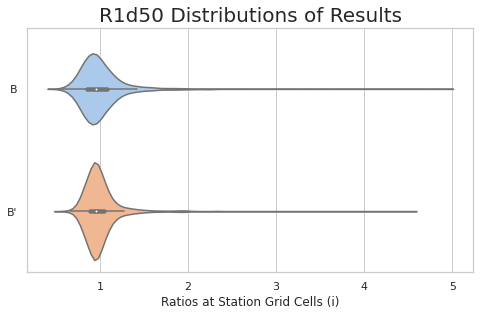

In [14]:
import seaborn as sns

sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(8, 4.5))

violindata = np.concatenate([df.ratio, ratio_field[df.irlat, df.irlon]])

b_str = ["B" for x in df.ratio.values]
bp_str = ["B'" for x in ratio_field[df.irlat, df.irlon]]

vstrings = np.concatenate([b_str, bp_str])
vdf = pd.DataFrame({"Ratios at Station Grid Cells (i)": violindata, '': vstrings})

ax.set_title(f"{name} Distributions of Results", fontsize=20)
sns.violinplot(ax=ax, x="Ratios at Station Grid Cells (i)", y='', data=vdf, palette=sns.color_palette('pastel'))

Summarize reconstruction stats

In [15]:
print(
    "Northern fill value:"
    "\n"
    "Reconstruction", reconstructed_field_strip_mean,
    "\n"
    "UAA_station_mean", UAA_station_mean,
    "\n"
    "Combined", combined_ratio_station_mean
)

Northern fill value:
Reconstruction 31.426368021364475 
UAA_station_mean 25.389714145 
Combined 28.408041083182237


Convert back to degC if K was used in previous steps. Generate dataset.

In [16]:
if ds[dv].attrs["units"] == "degC" and "degC" in station_dv:
    print("Convert back to degC")
    K = 273.15 # K
    reconstructed_field -= K
    df[station_dv] -= K
#     ds[dv].attrs["units"] = "degC"

ds_recon = gen_dataset(dv, reconstructed_field, ds.rlat, ds.rlon, ds.lat, ds.lon, unit=ds[dv].attrs["units"])

# Load in NBCC Tables for Comparisons

In [17]:
nrc_path = resource_filename("climpyrical", nbcc_loc_path)
df_nrc = pd.read_excel(nrc_path).iloc[:-1]

# fill problem values with better values from 2015
id_typo = df_nrc[(df_nrc['2020 Longitude'] > 0) | (df_nrc['2020 Latitude'] < 40)].index
df_nrc.loc[id_typo, '2020 Longitude'] = df_nrc['2015 Long.'].values[id_typo]
df_nrc.loc[id_typo, '2020 Latitude'] = df_nrc['2015 Lat.'].values[id_typo]

# process to get the model values
df_nrc.rename(columns={"2020 Longitude": "lon",
                      "2020 Latitude": "lat"})

df_nrc_matched = pd.DataFrame(
    {
     'Location': df_nrc.Location, 
     'Prov': df_nrc.Prov,
     "2020 Elev (m)": df_nrc["2020 Elev (m)"],
     'lon': df_nrc['2020 Longitude'], 
     'lat': df_nrc['2020 Latitude']
     }
    
)

__This step aims to correct the final field to the NBCC 2015 results.__

This is configurable by setting `nbcc_median_correction` to True or False.

1) Find the median of these values. Compute the difference, d = median(R) - median(NRC), and ratio, f = median(R)/median(NRC) 

2) For the non-temperature DVs and HDD, apply the multiplicative correction (1/f)*R_j over the entire reconstruction grid. For the temperature DVs, apply the correction as R_j - d

In [18]:
value = medians["value"]
action = medians["action"]

if action != "add" and action != "multiply" and action != "None":
    raise ValueError("Please provide either add or multiply or None actions in config.")

    
dfp = add_model_values(ds=ds_recon, df=df_nrc_matched)
reconstructed_field_med = ds_recon[dv].values

if nbcc_median_correction:
    if value != "None" or action != "None":
#         med_pcic = np.nanmedian(dfp["model_values"])
        med_pcic = np.nanmean(dfp["model_values"])

        if action == "multiply":
            fr = med_pcic/value
            reconstructed_field_med = (1/fr)*reconstructed_field_med
            print("f:", fr)
        if action == "add":
            d = med_pcic - value
            reconstructed_field_med = reconstructed_field_med - d
            print("d:", d)

INFO:root:Detect units: mm


INFO:root:rlat or rlon not detected in input file.converting assumes WGS84 coords to rotated pole


INFO:root:Matching coordinates now


INFO:root:Locating corresponding model valuesInterpolating to nearest if matched model value is NaN


f: 0.8958929536560745


Re-create dataset if median correction applied

In [19]:
ds_recon = gen_dataset(dv, reconstructed_field_med, ds.rlat, ds.rlon, ds.lat, ds.lon, unit=ds[dv].attrs["units"])

Populate with headers from the input processed model.

In [20]:
if ds.attrs:
    all_keys = set(ds_recon.variables).union(set(ds_recon.dims))
    for key in all_keys:
        ds_recon[key].attrs = ds[key].attrs
    attr_dict = ds.attrs
    attr_dict["Climpyrical"] = (
        "CanRCM4 Reconstruction contains"
        "hybrid station and model data using"
        "Climpyrical (https://github.com/pacificclimate/climpyrical)"
    )

    ds_recon.attrs = attr_dict
else:
    raise warnings.warn("No attributes detected in dataset file")

In [21]:
ds_recon.to_netcdf(
    resource_filename(
        "climpyrical",
        f"{output_reconstruction_path}{name}_reconstruction.nc"
    ),
    mode="w"
)